# *deepBreaks* applications
## *deepBreaks* identifies amino acids associated with color sensitivity  
In this study we are trying to use 175 amino-acid sequences to train predictive models for predicting a phenotype which is the the maximum wavelength absobption.  
After that, we use the top 3 models to study their feature importances and merge their results. We cover all three steps of preprocessing, modelling, and interpretaion of the models. Finally we vizualize the results of the models and prioritize the most imposrtant sites of the sequences.  
![alt text](../img/lite_mar/LITE_Mar.png)

In [1]:
# importing deepBreaks libraries 
from deepBreaks import preprocessing as prp
from deepBreaks import visualization as viz
from deepBreaks import models as ml
import os
import datetime
import warnings

In [2]:
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

In [3]:
# defining user params, file pathes, analysis type

# path to sequences
seqFileName = '/Users/mbagh/Documents/RahLab/deepBreaks_data/lite_mar/msa_RodOpsinLambdaMax.fasta' 

# path to metadata
metaDataFileName = '~/Documents/RahLab/deepBreaks_data/lite_mar/meta_RodOpsinLambdaMax.tsv' 

# name of the phenotype
mt = 'LambdaMax'

# type of the sequences
seq_type = 'amino-acid'

# type of the analysis if it is a classification model, then we put cl instead of reg
anaType = 'reg' 
sampleFrac=1

In [4]:
# making a unique directory for saving the reports of the analysis
print('direcory preparation')
dt_label = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
seqFile = seqFileName.split('.')[0]
report_dir = str(seqFile +'_' + mt + '_' + dt_label)
os.makedirs(report_dir)

direcory preparation


In [5]:
%%time
print('reading meta-data')
# importing metadata
metaData = prp.read_data(metaDataFileName, seq_type = None, is_main=False)
print('metaData:', metaData.shape)

# importing sequences data
print('reading fasta file')
df = prp.read_data(seqFileName, seq_type = seq_type, is_main=True, gap_threshold=0.7)

positions = df.shape[1]
print('Done')
print('Shape of data is: ', df.shape)

reading meta-data
metaData: (175, 2)
reading fasta file
Done
Shape of data is:  (175, 354)
CPU times: user 74.5 ms, sys: 6.82 ms, total: 81.3 ms
Wall time: 87.8 ms


**Attention**: metadata and sequences data should have the names as their row names and for each sequence their must be a value in the meta data file.

In [6]:
print('metadata looks like this:')
metaData.head()

metadata looks like this:


Species  LambdaMax
1_KC250344.1_Acipenser_transmontanus  Acipenser_transmontanus      540.0
2_AF137208.1_Amia_calva                            Amia_calva      527.0
3_HQ444181.1_Gymnothorax_favagineus    Gymnothorax_favagineus      488.0
4_HQ444182.1_Gymnothorax_reticularis  Gymnothorax_reticularis      486.0
5_HQ444180.1_Rhinomuraena_quaesita      Rhinomuraena_quaesita      498.0

In [7]:
print('sequence data looks like this:')
df.head()

sequence data looks like this:


p1   p2   p3   p4   p5   p6   p7   p8  \
1_KC250344.1_Acipenser_transmontanus  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2_AF137208.1_Amia_calva               NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3_HQ444181.1_Gymnothorax_favagineus   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
4_HQ444182.1_Gymnothorax_reticularis  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
5_HQ444180.1_Rhinomuraena_quaesita    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

                                       p9  p10  ... p345 p346 p347 p348 p349  \
1_KC250344.1_Acipenser_transmontanus  NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN   
2_AF137208.1_Amia_calva               NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN   
3_HQ444181.1_Gymnothorax_favagineus   NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN   
4_HQ444182.1_Gymnothorax_reticularis  NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN   
5_HQ444180.1_Rhinomuraena_quaesita    NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN   

                                     p350 p351 p352 p353 p354  
1_KC250344.1_Acipenser_transmontanus  NaN  NaN  NaN  NaN  NaN  
2_AF137208.1_Amia_calva               NaN  NaN  NaN  NaN  NaN  
3_HQ444181.1_Gymnothorax_favagineus   NaN  NaN  NaN  NaN  NaN  
4_HQ444182.1_Gymnothorax_reticularis  NaN  NaN  NaN  NaN  NaN  
5_HQ444180.1_Rhinomuraena_quaesita    NaN  NaN  NaN  NaN  NaN  

[5 rows x 354 columns]

### Preprocessing
In this step, we do all these steps:
1. dropping columns with a number of missing values above a certain threshold  
2. dropping zero entropy columns  
3. imputing missing values with the mode of that column  
4. replacing cases with a frequency below a threshold (default 1.5%) with the mode of that column
5. dropping zero entropy columns
6. use statistical tests (each position against the phenotype) and drop columns with p-values below a threshold (default 0.25)
7. one-hot encode the remaining columns
8. calculate the pair-wise distance matrix for all of the columns
9. use the distance matrix for DBSCAN and cluster the correlated positions together
10. keep only one column (closes to center of each cluster) for each group and drop the rest from the training data set

In [8]:
%%time
# taking care of missing data
print('Shape of data before missing/constant care: ', df.shape)
df = prp.missing_constant_care(df, missing_threshold=0.05)
print('Shape of data after missing/constant care: ', df.shape)

Shape of data before missing/constant care:  (175, 354)
Shape of data after missing/constant care:  (175, 249)
CPU times: user 182 ms, sys: 3.67 ms, total: 186 ms
Wall time: 188 ms


In [9]:
%%time
# taking care of ultra-rare cases
print('Shape of data before imbalanced care: ', df.shape)
df = prp.imb_care(dat=df, imbalance_threshold=0.025)
print('Shape of data after imbalanced care: ', df.shape)

Shape of data before imbalanced care:  (175, 249)
Shape of data after imbalanced care:  (175, 194)
CPU times: user 224 ms, sys: 6.06 ms, total: 230 ms
Wall time: 226 ms


In [10]:
%%time
# you may want to perform your analysis only on a random sample of the positions.
# Here you can have a random sample of your main data set.
print('number of columns of main data befor: ', df.shape[1])
df = prp.col_sampler(dat=df, sample_frac=sampleFrac)
print('number of columns of main data after: ', df.shape[1])

number of columns of main data befor:  194
number of columns of main data after:  194
CPU times: user 111 µs, sys: 9 µs, total: 120 µs
Wall time: 119 µs


In [11]:
%%time
# Use statistical tests to drop redundant features.
print('number of columns of main data befor: ', df.shape[1])
df_cleaned = prp.redundant_drop(dat=df, meta_dat=metaData,
                        feature=mt, model_type=anaType,
                        threshold=0.25,
                        report_dir=report_dir)
print('number of columns of main data after: ', df_cleaned.shape[1])

number of columns of main data befor:  194
number of columns of main data after:  102
CPU times: user 241 ms, sys: 5.72 ms, total: 247 ms
Wall time: 246 ms


In [12]:
%%time
print('one-hot encoding the dataset')
df_cleaned = prp.get_dummies(dat=df_cleaned, drop_first=True)

one-hot encoding the dataset
CPU times: user 56.4 ms, sys: 3.66 ms, total: 60.1 ms
Wall time: 58.2 ms


In [13]:
%%time
print('calculating the distance matrix')
cr = prp.distance_calc(dat=df_cleaned,
                       dist_method='correlation',
                       report_dir=report_dir)
print(cr.shape)

calculating the distance matrix
(185, 185)
CPU times: user 75.1 ms, sys: 7.41 ms, total: 82.5 ms
Wall time: 82.4 ms


In [14]:
print('The distance matrix looks like this.\n The values are between 0 (exact the same) and 1 (non-related).')
cr.head()

The distance matrix looks like this.
 The values are between 0 (exact the same) and 1 (non-related).


p4_T        p5_GAP        p6_GAP        p7_GAP      p7_P  \
p4_T    0.000000e+00  2.220446e-16  2.220446e-16  2.220446e-16  0.158108   
p5_GAP  2.220446e-16  0.000000e+00  2.220446e-16  2.220446e-16  0.158108   
p6_GAP  2.220446e-16  2.220446e-16  0.000000e+00  2.220446e-16  0.158108   
p7_GAP  2.220446e-16  2.220446e-16  2.220446e-16  0.000000e+00  0.158108   
p7_P    1.581085e-01  1.581085e-01  1.581085e-01  1.581085e-01  0.000000   

            p7_Q      p8_F    p8_GAP      p8_N      p8_Y  ...    p338_V  \
p4_T    0.882498  0.751384  0.053861  0.616618  0.688195  ...  0.775993   
p5_GAP  0.882498  0.751384  0.053861  0.616618  0.688195  ...  0.775993   
p6_GAP  0.882498  0.751384  0.053861  0.616618  0.688195  ...  0.775993   
p7_GAP  0.882498  0.751384  0.053861  0.616618  0.688195  ...  0.775993   
p7_P    0.745624  0.774154  0.110182  0.624953  0.629638  ...  0.733924   

        p342_GAP    p342_R  p345_GAP    p345_S  p346_GAP    p346_V    p347_S  \
p4_T    0.271453  0.893052  0.478613  0.508823  0.514743  0.616618  0.543832   
p5_GAP  0.271453  0.893052  0.478613  0.508823  0.514743  0.616618  0.543832   
p6_GAP  0.271453  0.893052  0.478613  0.508823  0.514743  0.616618  0.543832   
p7_GAP  0.271453  0.893052  0.478613  0.508823  0.514743  0.616618  0.543832   
p7_P    0.449022  0.872967  0.672035  0.686941  0.670112  0.758844  0.708881   

          p348_S    p348_T  
p4_T    0.633100  0.671569  
p5_GAP  0.633100  0.671569  
p6_GAP  0.633100  0.671569  
p7_GAP  0.633100  0.671569  
p7_P    0.673538  0.870681  

[5 rows x 185 columns]

In [16]:
%%time
print('finding colinear groups')
dc_df = prp.db_grouped(dat=cr,
                       report_dir=report_dir,
                       threshold=.25)

finding colinear groups
CPU times: user 65.1 ms, sys: 27.5 ms, total: 92.6 ms
Wall time: 143 ms


In [17]:
print('The result of the last step is a dataframe with two columns,\
1)feature and 2)group.\nif there are no groups, it will be an empty dataframe')
dc_df.head()

The result of the last step is a dataframe with two columns,1)feature and 2)group.
if there are no groups, it will be an empty dataframe


feature group
0    p4_T    g0
1  p5_GAP    g0
2  p6_GAP    g0
3  p7_GAP    g0
4    p7_P    g0

Then, we pass the above calculated groupes into the *group_feature* function. This function finds the distance of all the group members to the center of the group (median). The result will be a dictionary of columns like this:  
\
{\
group1_representativ:[member1, member2,...],  
group2_representativ:[member1, member2,...],...  
}

In [18]:
%%time
print('grouping features')
dc = prp.group_features(dat=df_cleaned,
                        group_dat=dc_df,
                        report_dir=report_dir)

grouping features
CPU times: user 69.1 ms, sys: 3.48 ms, total: 72.6 ms
Wall time: 71.2 ms


In [19]:
print('dropping correlated features')
print('Shape of data before collinearity care: ', df_cleaned.shape)
df_cleaned = prp.cor_remove(df_cleaned, dc)
print('Shape of data after collinearity care: ', df_cleaned.shape)

dropping correlated features
Shape of data before collinearity care:  (175, 185)
Shape of data after collinearity care:  (175, 98)


In [20]:
# merge with metadata
df = df.merge(metaData[mt], left_index=True, right_index=True)
df_cleaned = df_cleaned.merge(metaData[mt], left_index=True, right_index=True)

## Modelling
In this step, we try to fit multiple models to the training dataset and rank them based on their performance. By default, we select the top 3 three models for further analysis.  
During this step, deepBreaks creates a CSV file containing all the fitted models with their performance metrics. These metrics are based on an average of 10-fold cross-validation.

In [23]:
%%time
models_to_select = 5 # number of top models to select
trained_models = ml.model_compare(X_train=df_cleaned.loc[:, df_cleaned.columns != mt],
                                  y_train=df_cleaned.loc[:, mt],
                                  sort_by='R2',n_positions=positions,
                                  grouped_features=dc, report_dir=report_dir,
                                  ana_type=anaType, select_top=models_to_select)

Fitting rf_with_default_parameters
Fitting rf_max_depth=4_n_estimators=500
Fitting rf_max_depth=4_n_estimators=1000
Fitting rf_max_depth=6_n_estimators=500
Fitting rf_max_depth=6_n_estimators=1000
Fitting rf_max_depth=8_n_estimators=500
Fitting rf_max_depth=8_n_estimators=1000
Fitting Adaboost_with_default_parameters
Fitting Adaboost_learning_rate=0.01_n_estimators=50
Fitting Adaboost_learning_rate=0.01_n_estimators=100
Fitting Adaboost_learning_rate=0.05_n_estimators=50
Fitting Adaboost_learning_rate=0.05_n_estimators=100
Fitting et_with_default_parameters
Fitting et_max_depth=4_n_estimators=500
Fitting et_max_depth=4_n_estimators=1000
Fitting et_max_depth=6_n_estimators=500
Fitting et_max_depth=6_n_estimators=1000
Fitting et_max_depth=8_n_estimators=500
Fitting et_max_depth=8_n_estimators=1000
Fitting gbc_with_default_parameters
Fitting dt_with_default_parameters
Fitting dt_max_depth=4
Fitting dt_max_depth=6
Fitting dt_max_depth=8
Fitting lr_with_default_parameters
Fitting Lasso_with

In [26]:
# to access the importances
model_names = list(trained_models.keys())
first_model_imp = viz._importance_to_df(trained_models[model_names[0]]['importance'])
first_model_imp.head()

feature     value  standard_value
0        1  0.000000        0.000000
1        2  0.000000        0.000000
2        3  0.000000        0.000000
3        4  1.428983        0.082324
4        5  1.428983        0.082324

In [28]:
print('Available information for each model:')
print(trained_models[model_names[0]].keys())

Available information for each model:
dict_keys(['metrics', 'importance', 'model'])


## Interpretation 
In this step, we use the training data set, positions, and the top models to report the most discriminative positions in the sequences associated with the phenotype.  
we report the feature importances for all top models separately and make a box plot (regression) or stacked bar plot (classification) for the top 4 positions.

BayesianRidge_with_default_parameters Done
BayesianRidge_with_default_parameters  Done
rf_max_depth=6_n_estimators=1000 Done
rf_max_depth=6_n_estimators=1000  Done
rf_max_depth=6_n_estimators=500 Done
rf_max_depth=6_n_estimators=500  Done
rf_max_depth=8_n_estimators=1000 Done
rf_max_depth=8_n_estimators=1000  Done
rf_max_depth=8_n_estimators=500 Done
rf_max_depth=8_n_estimators=500  Done
mean Done


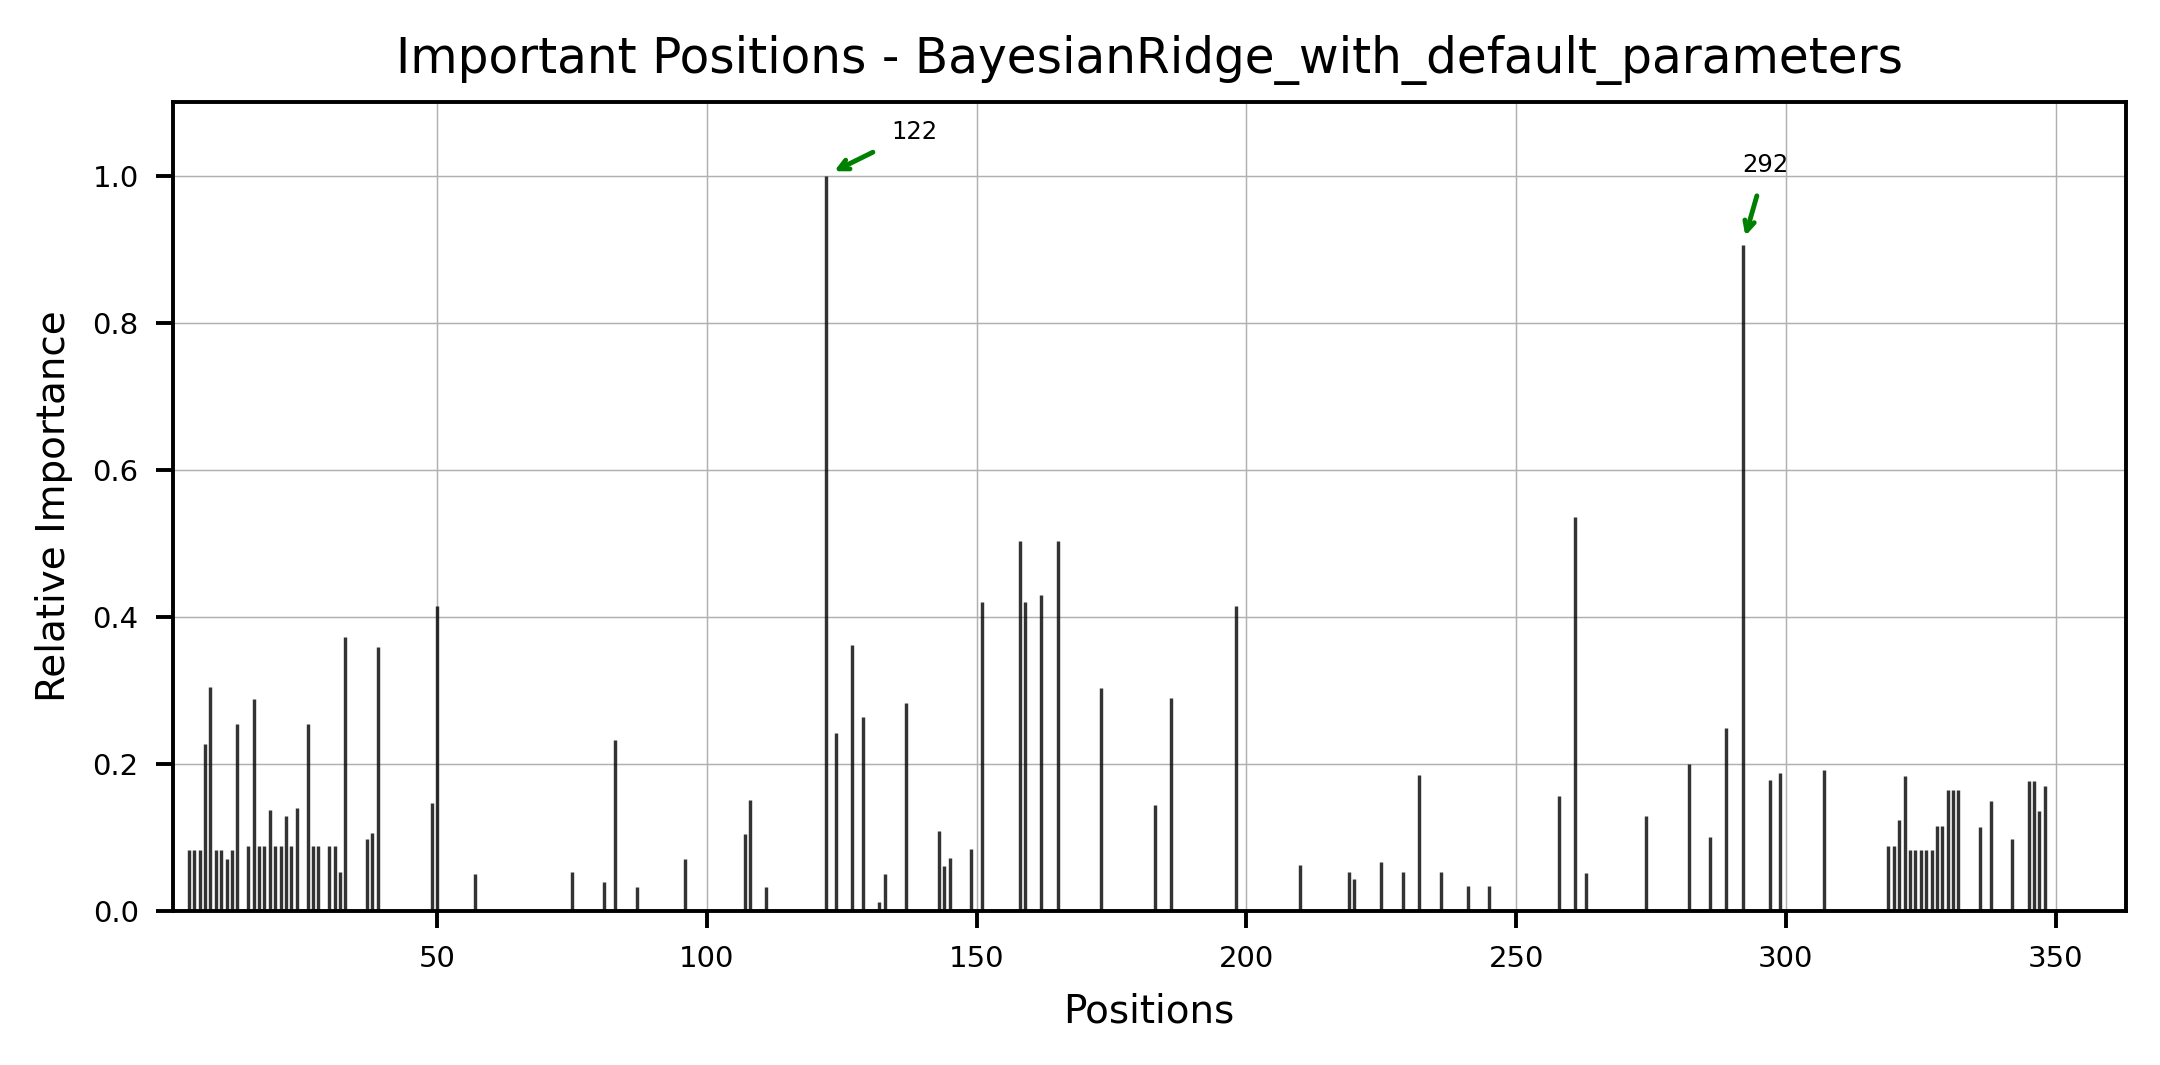

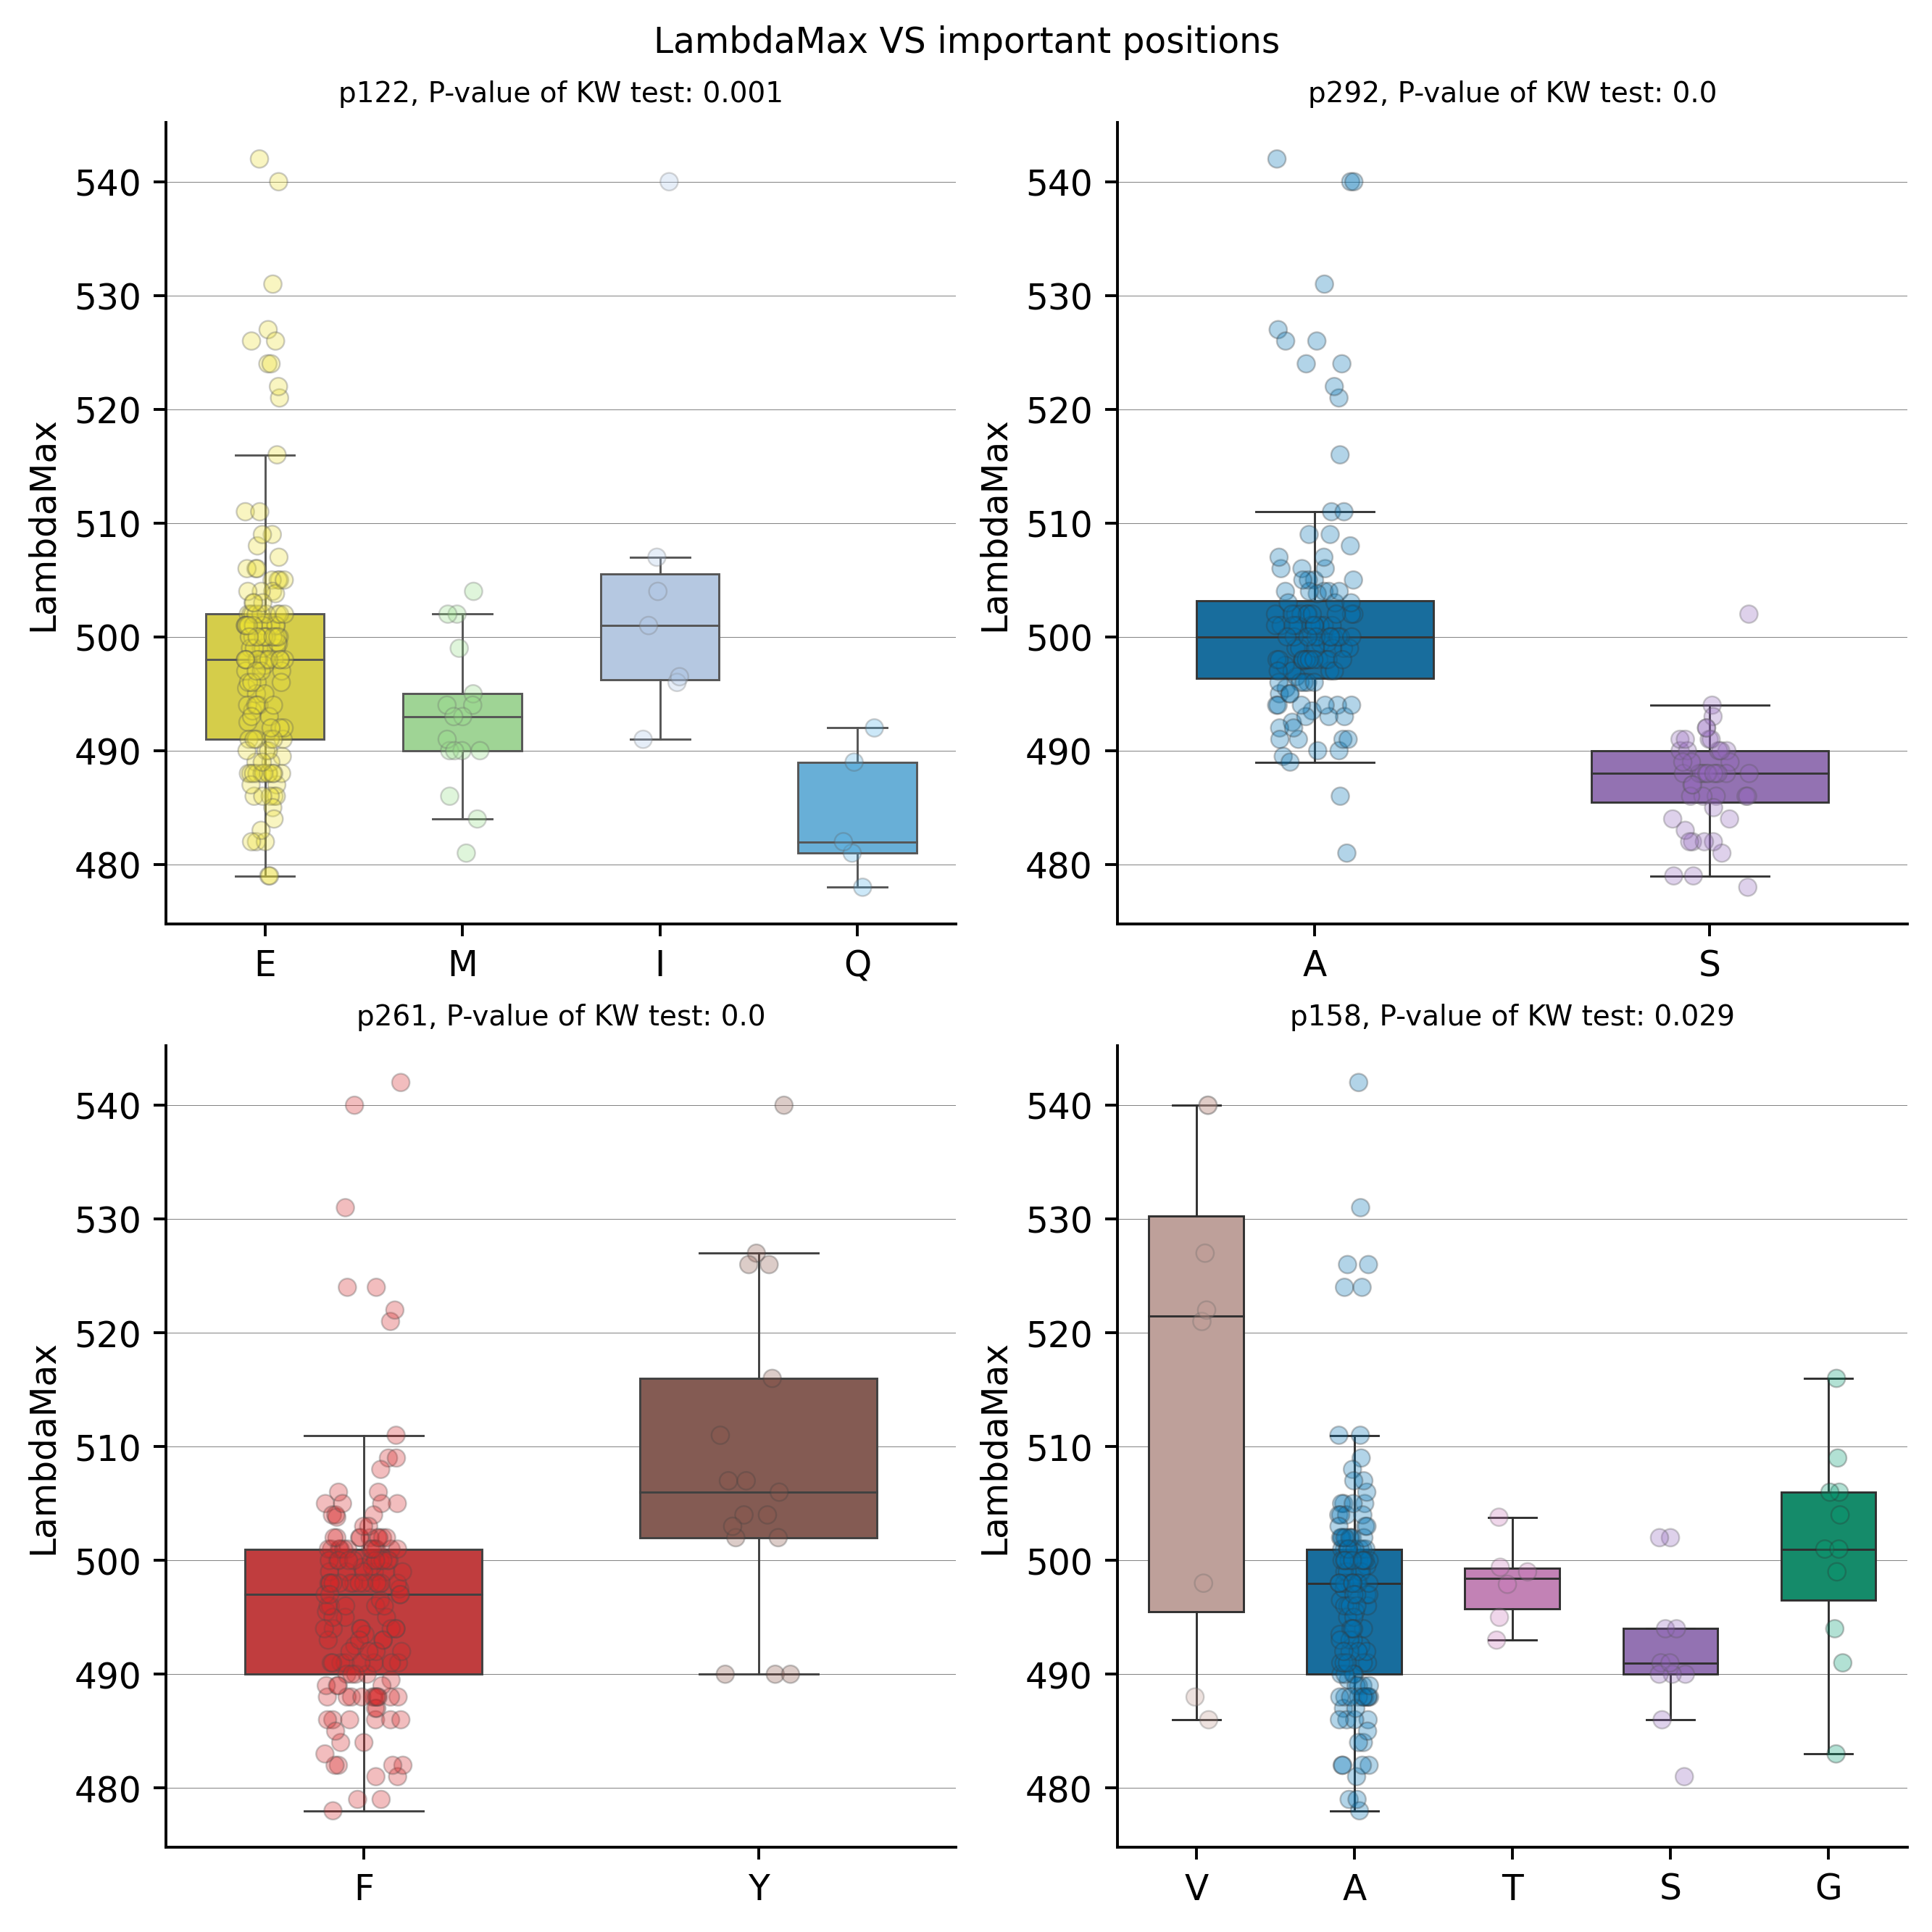

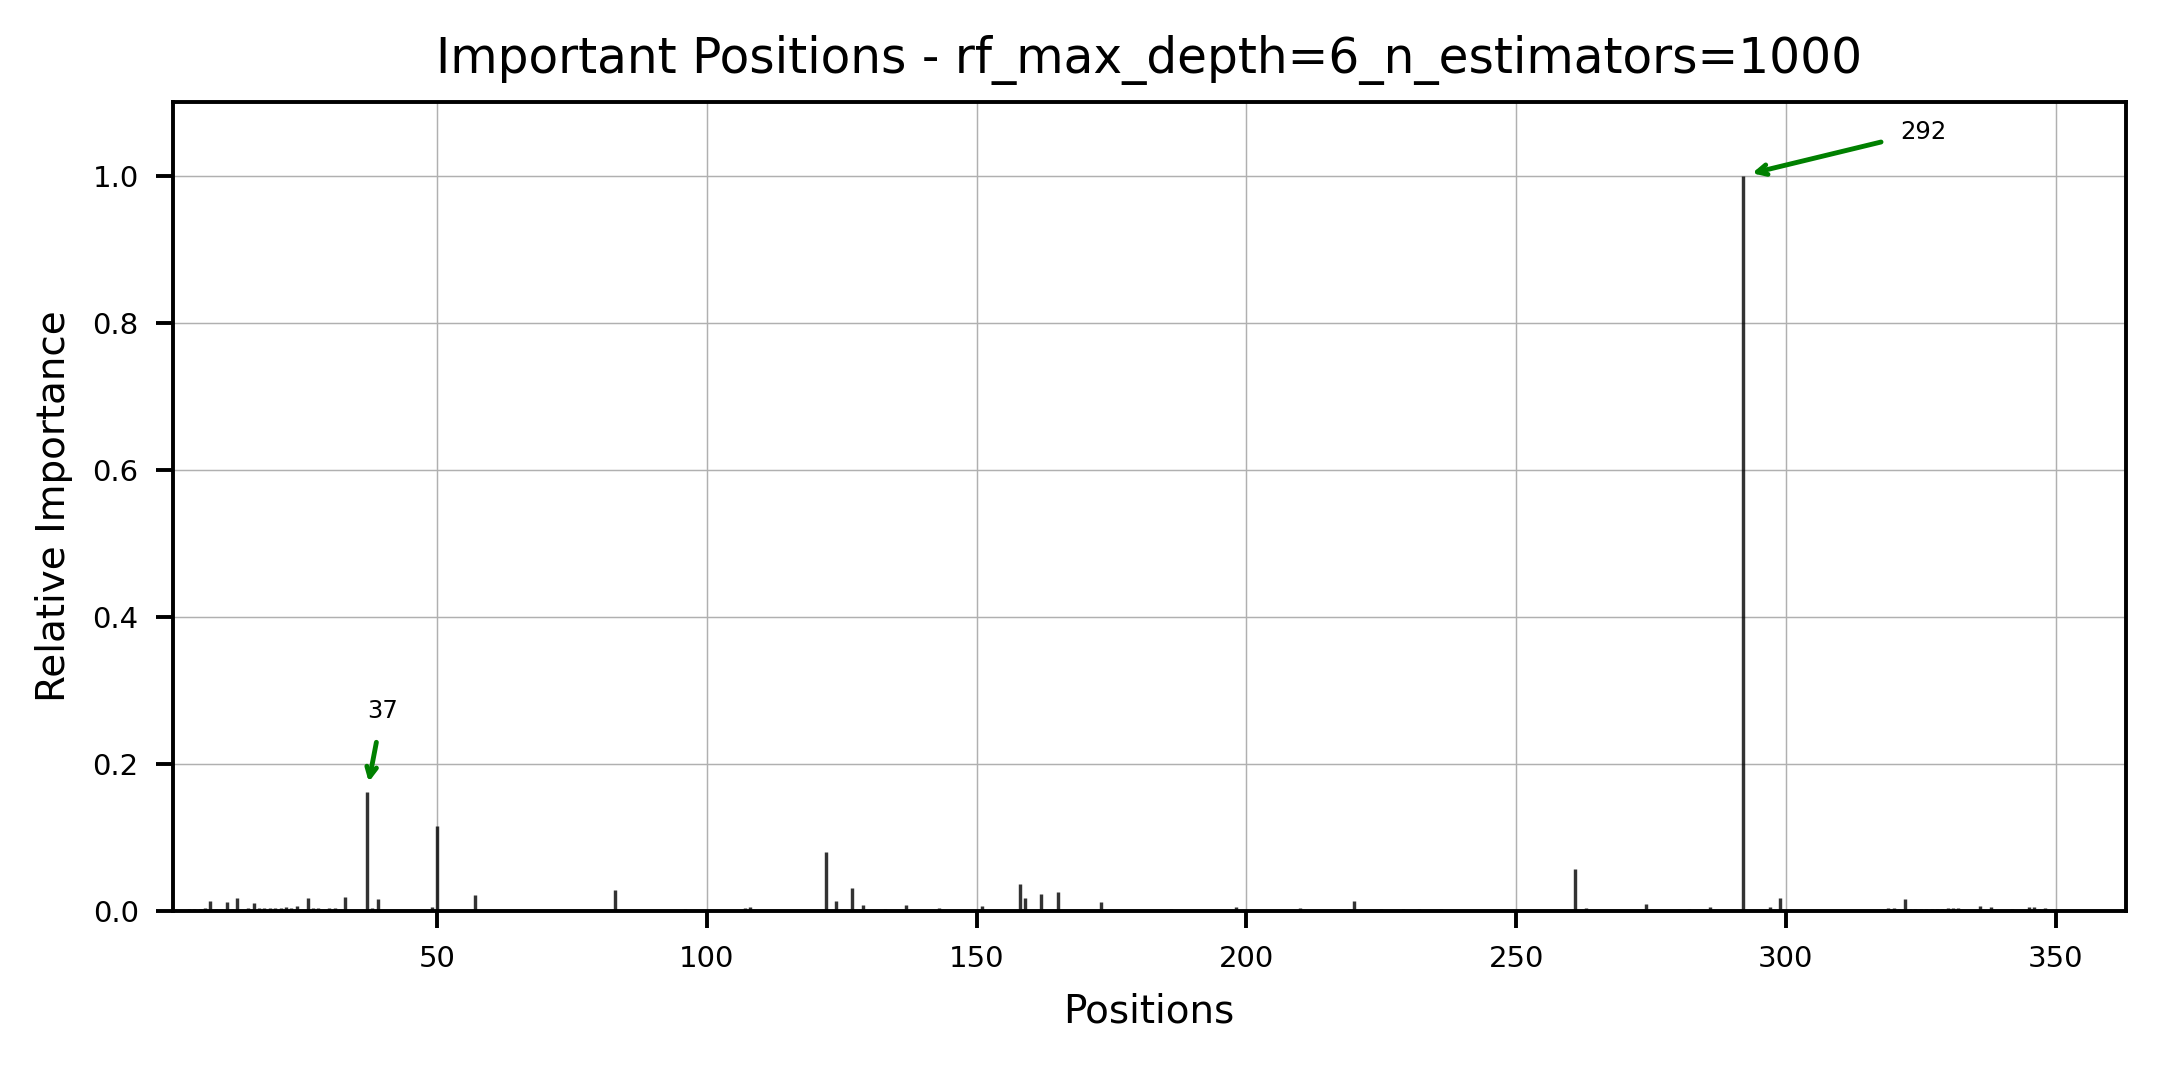

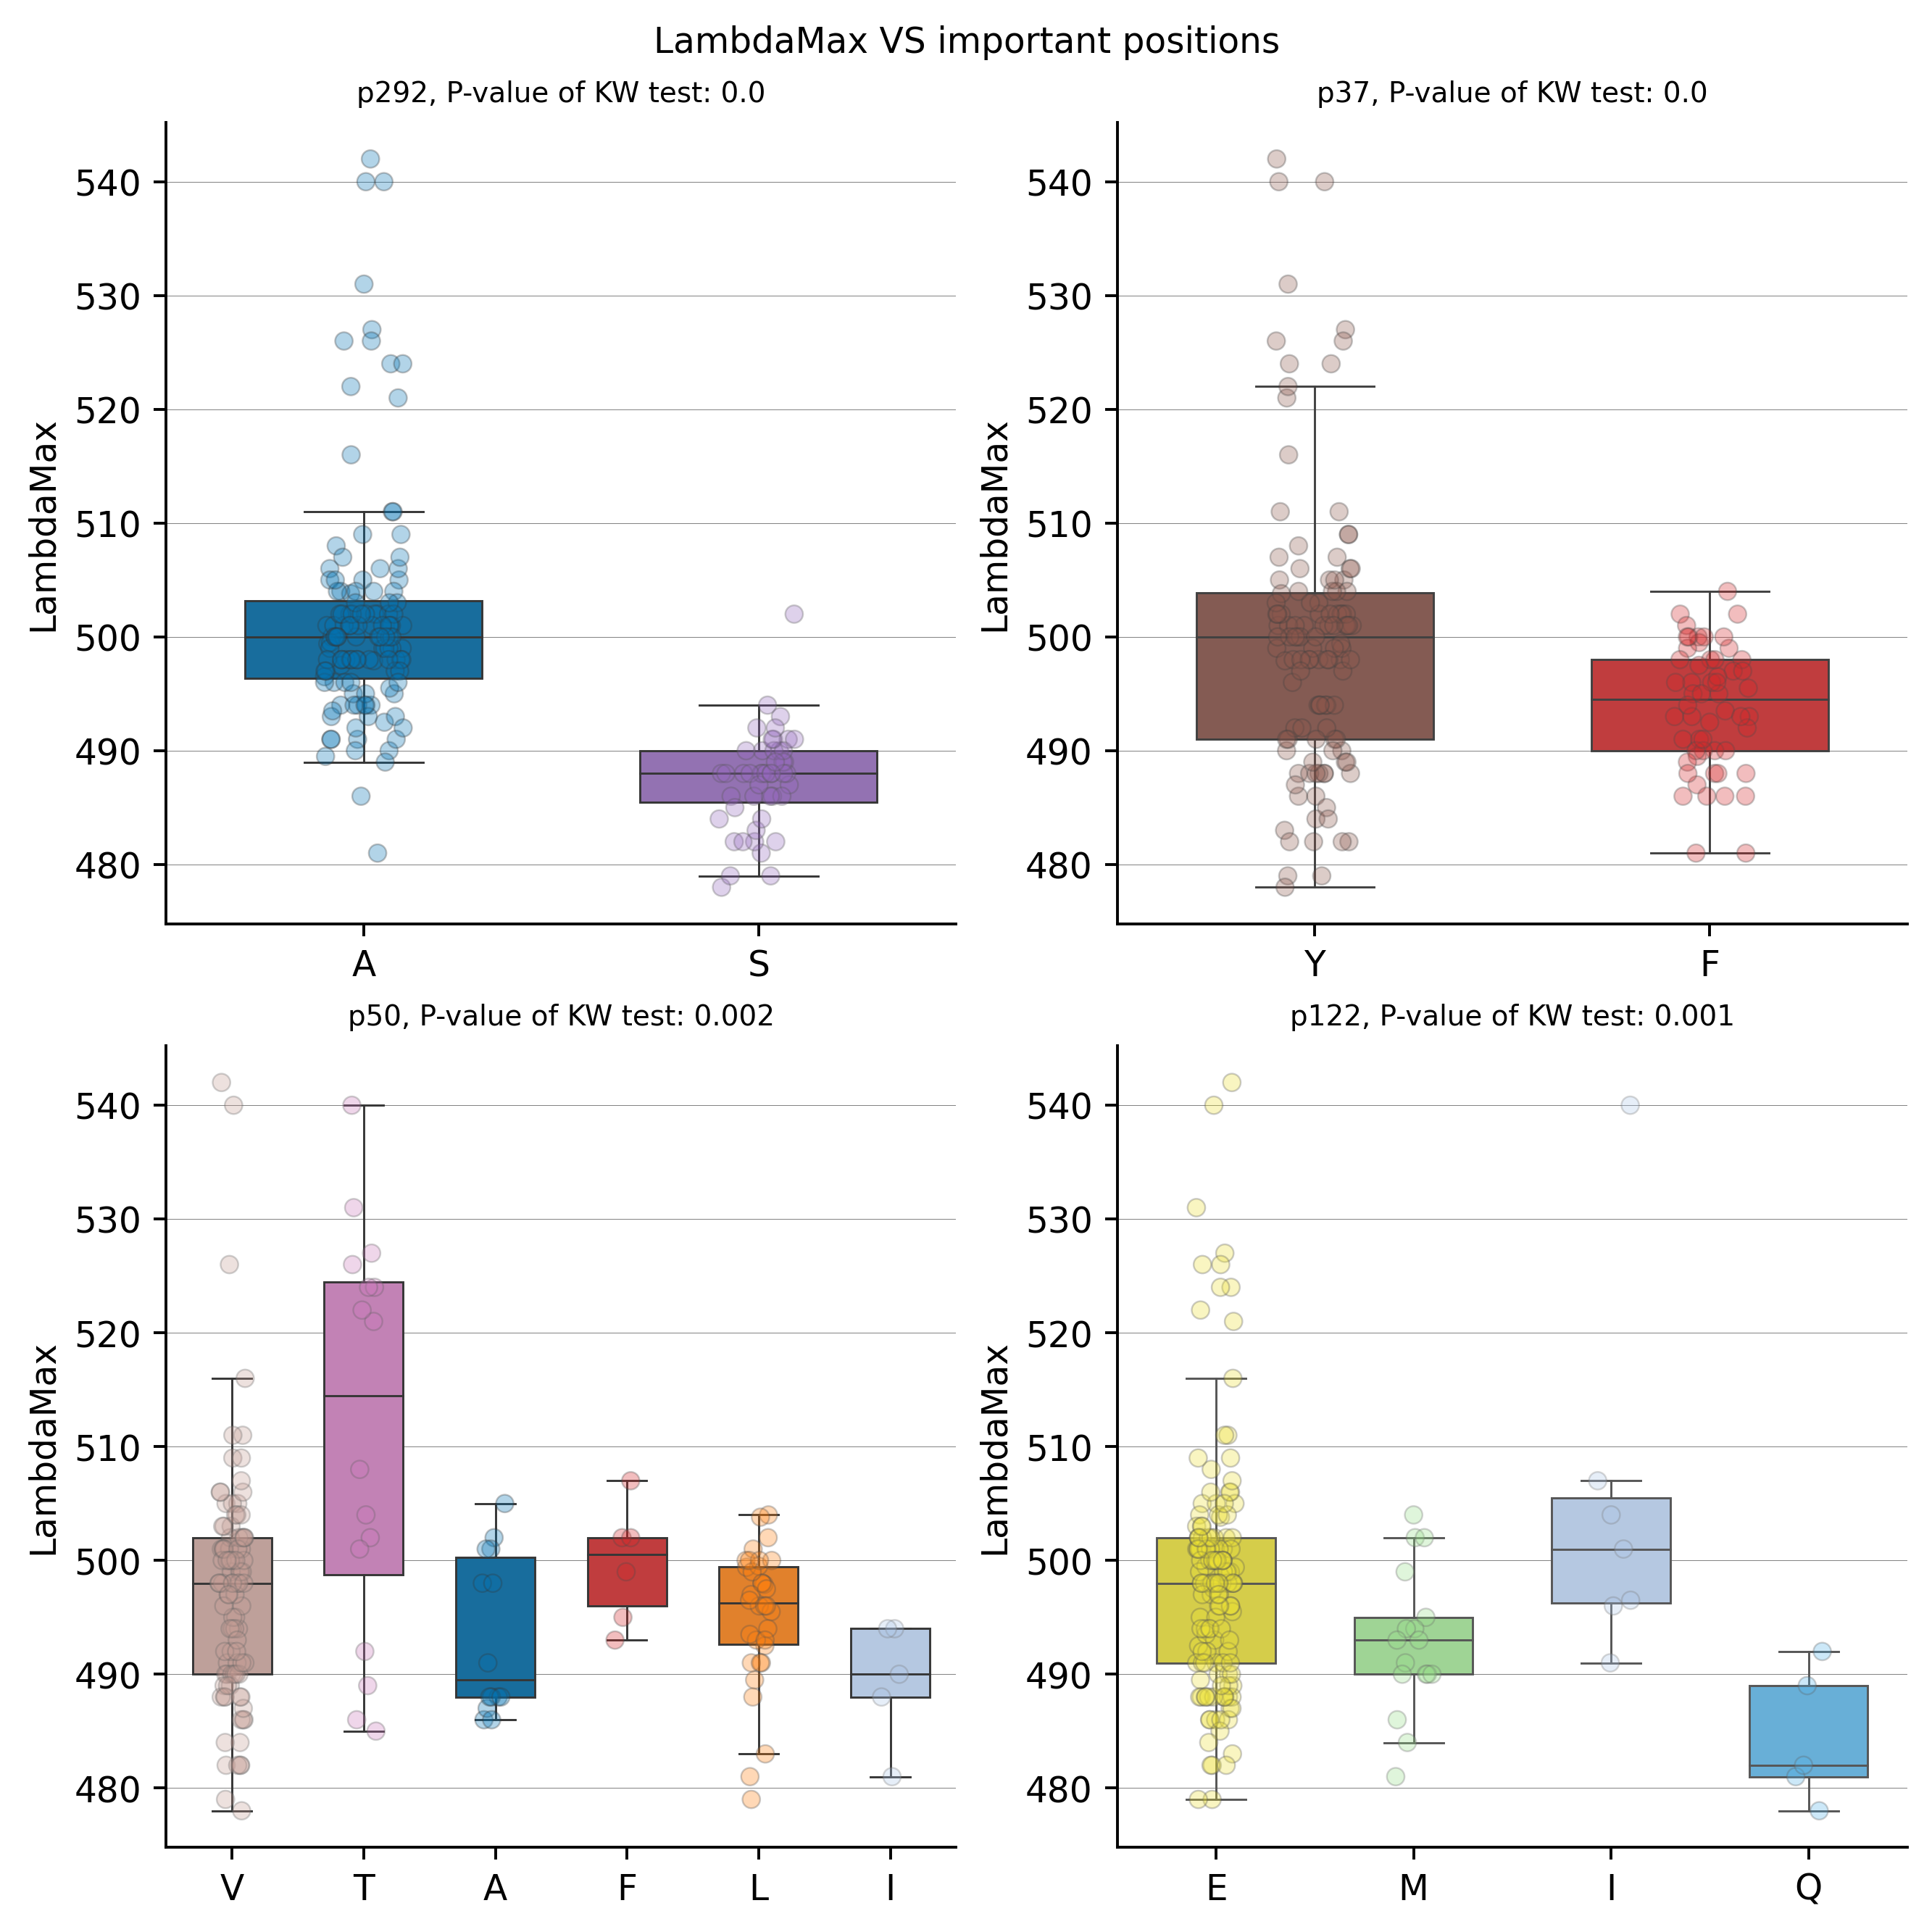

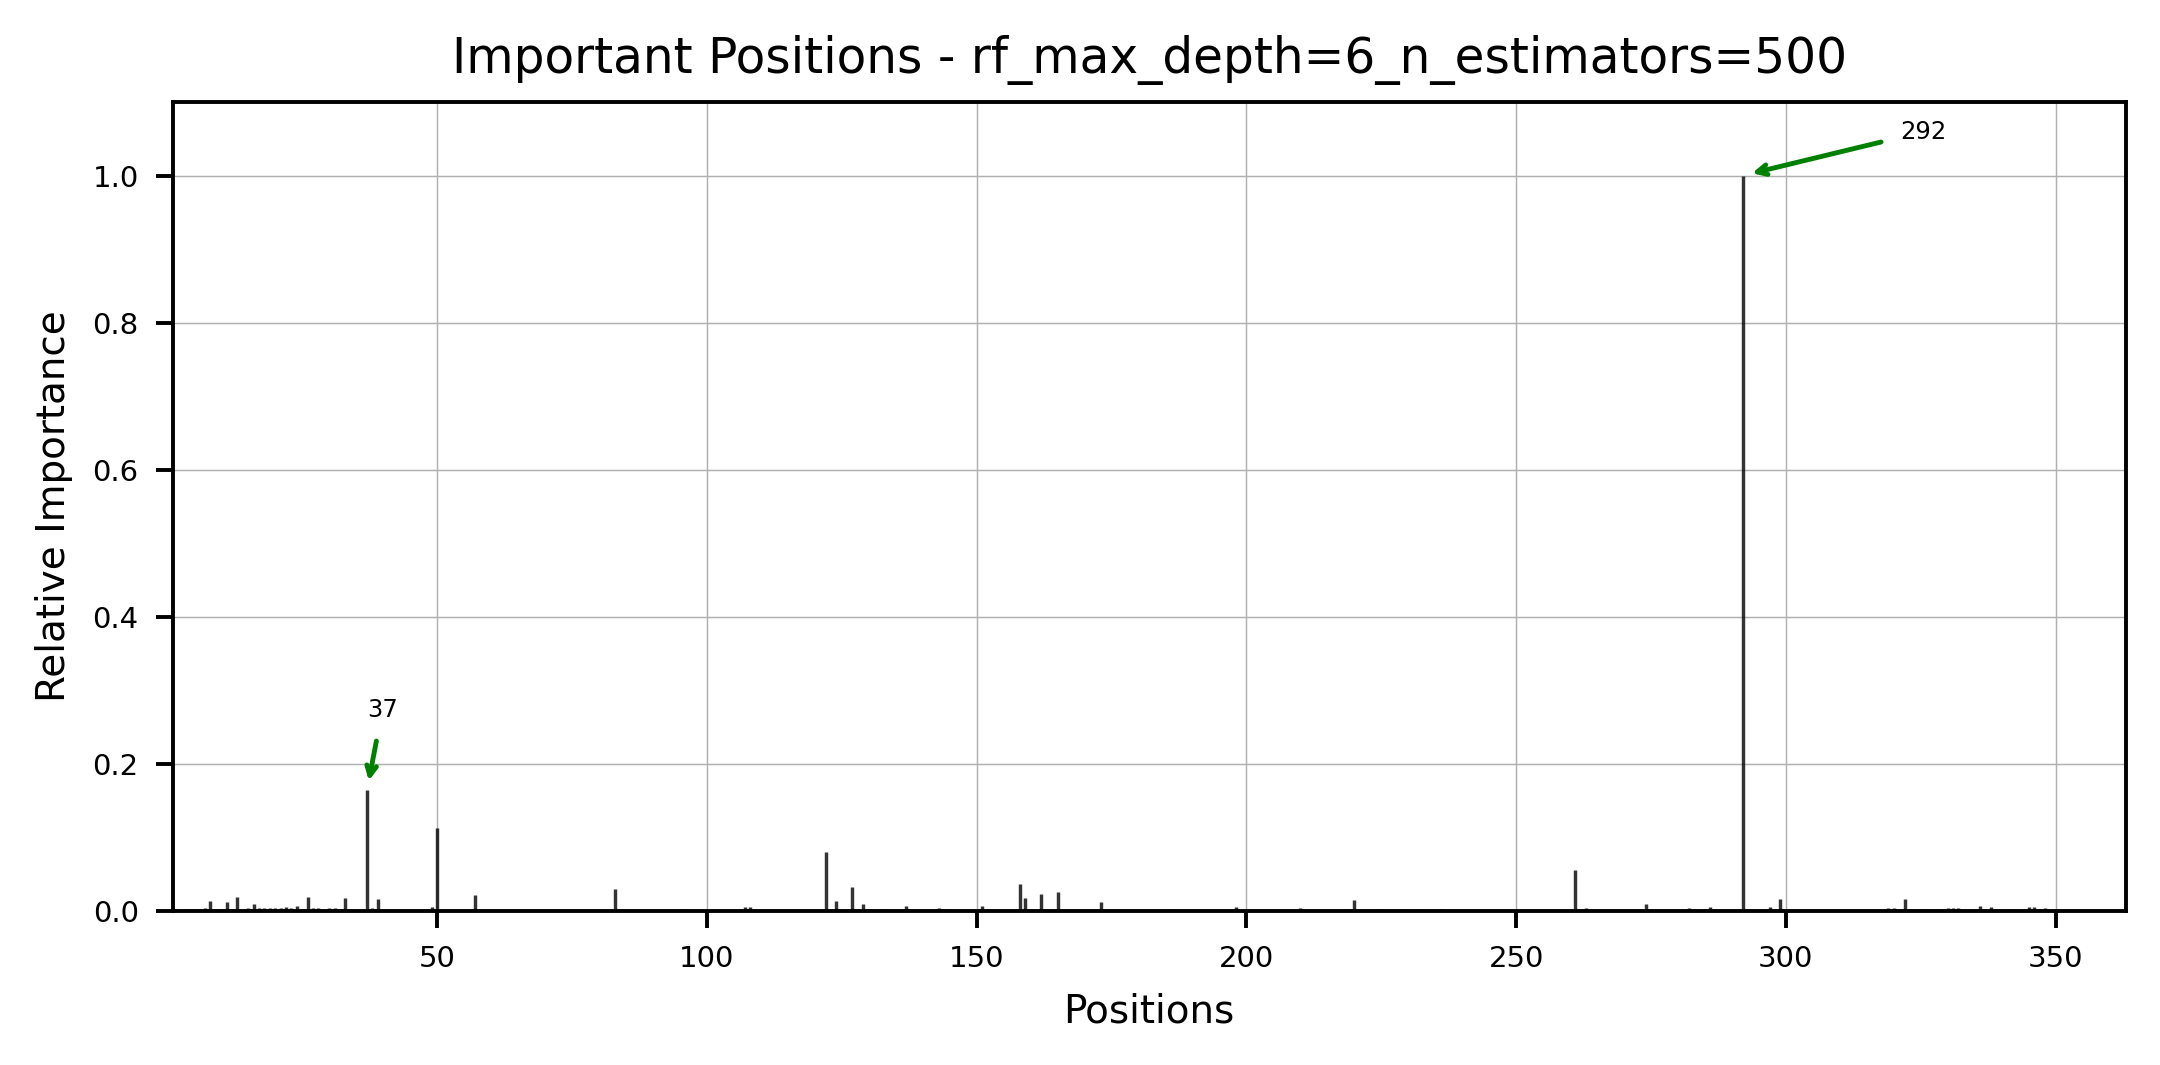

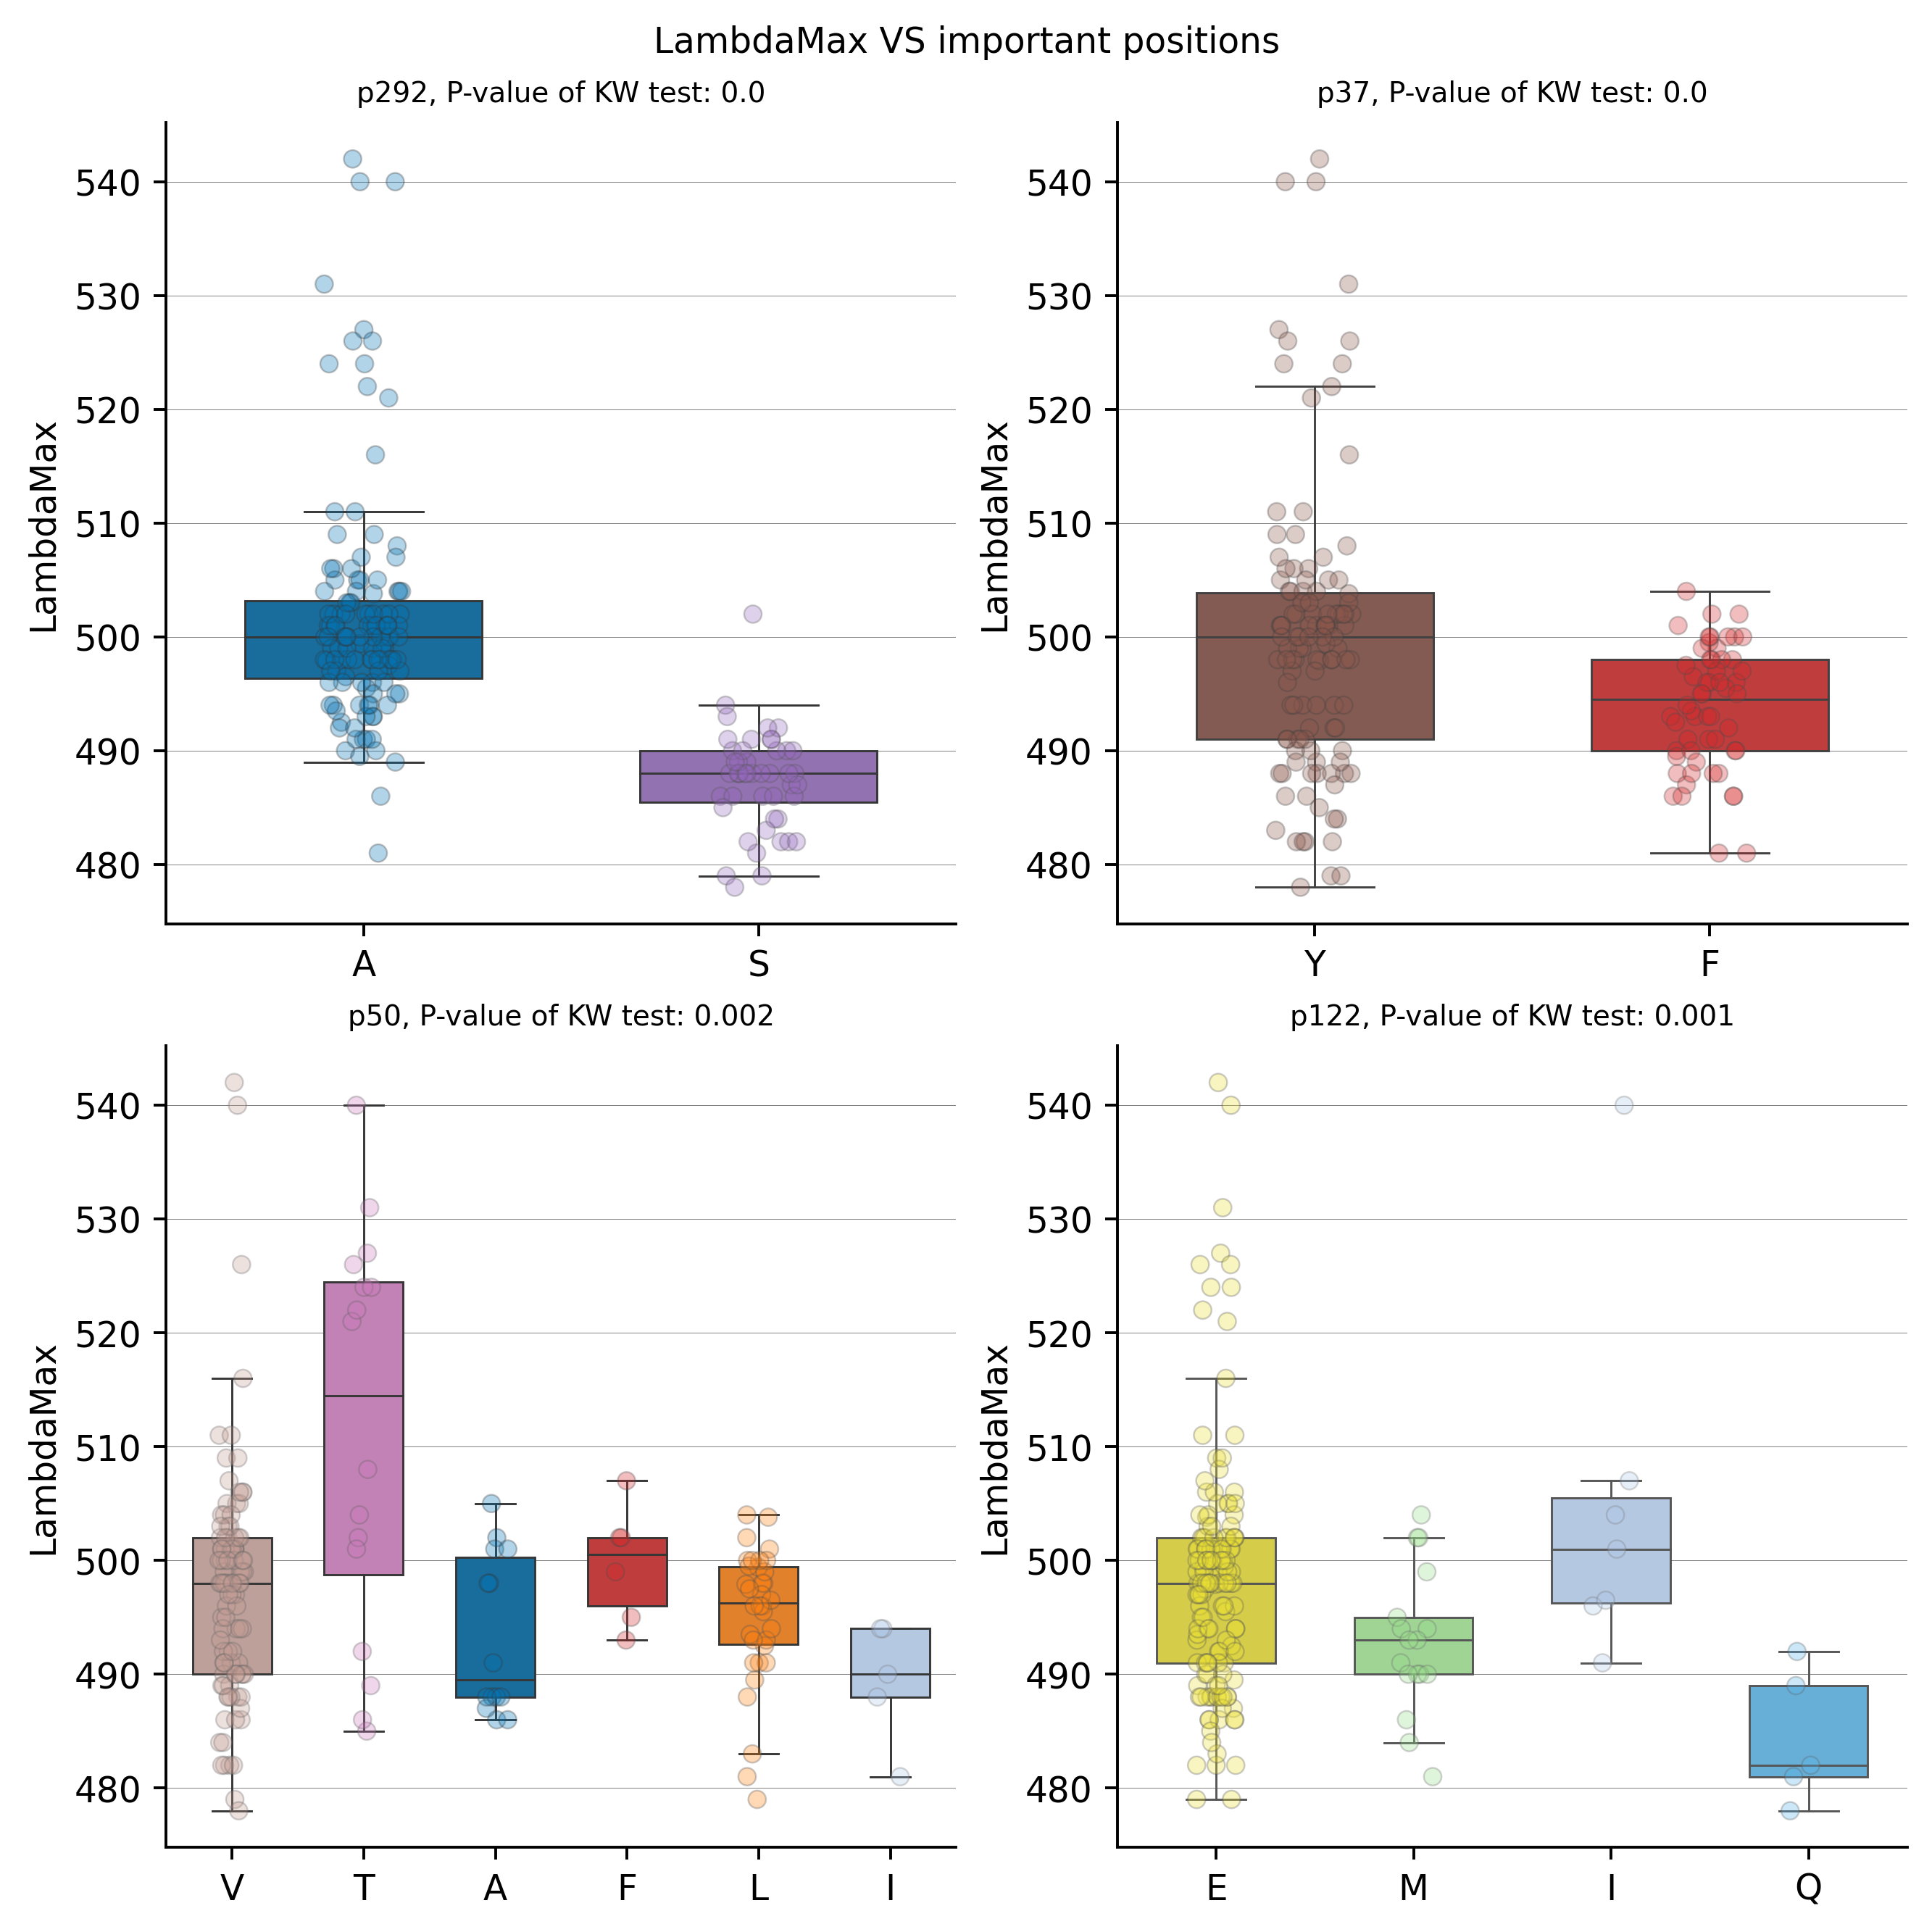

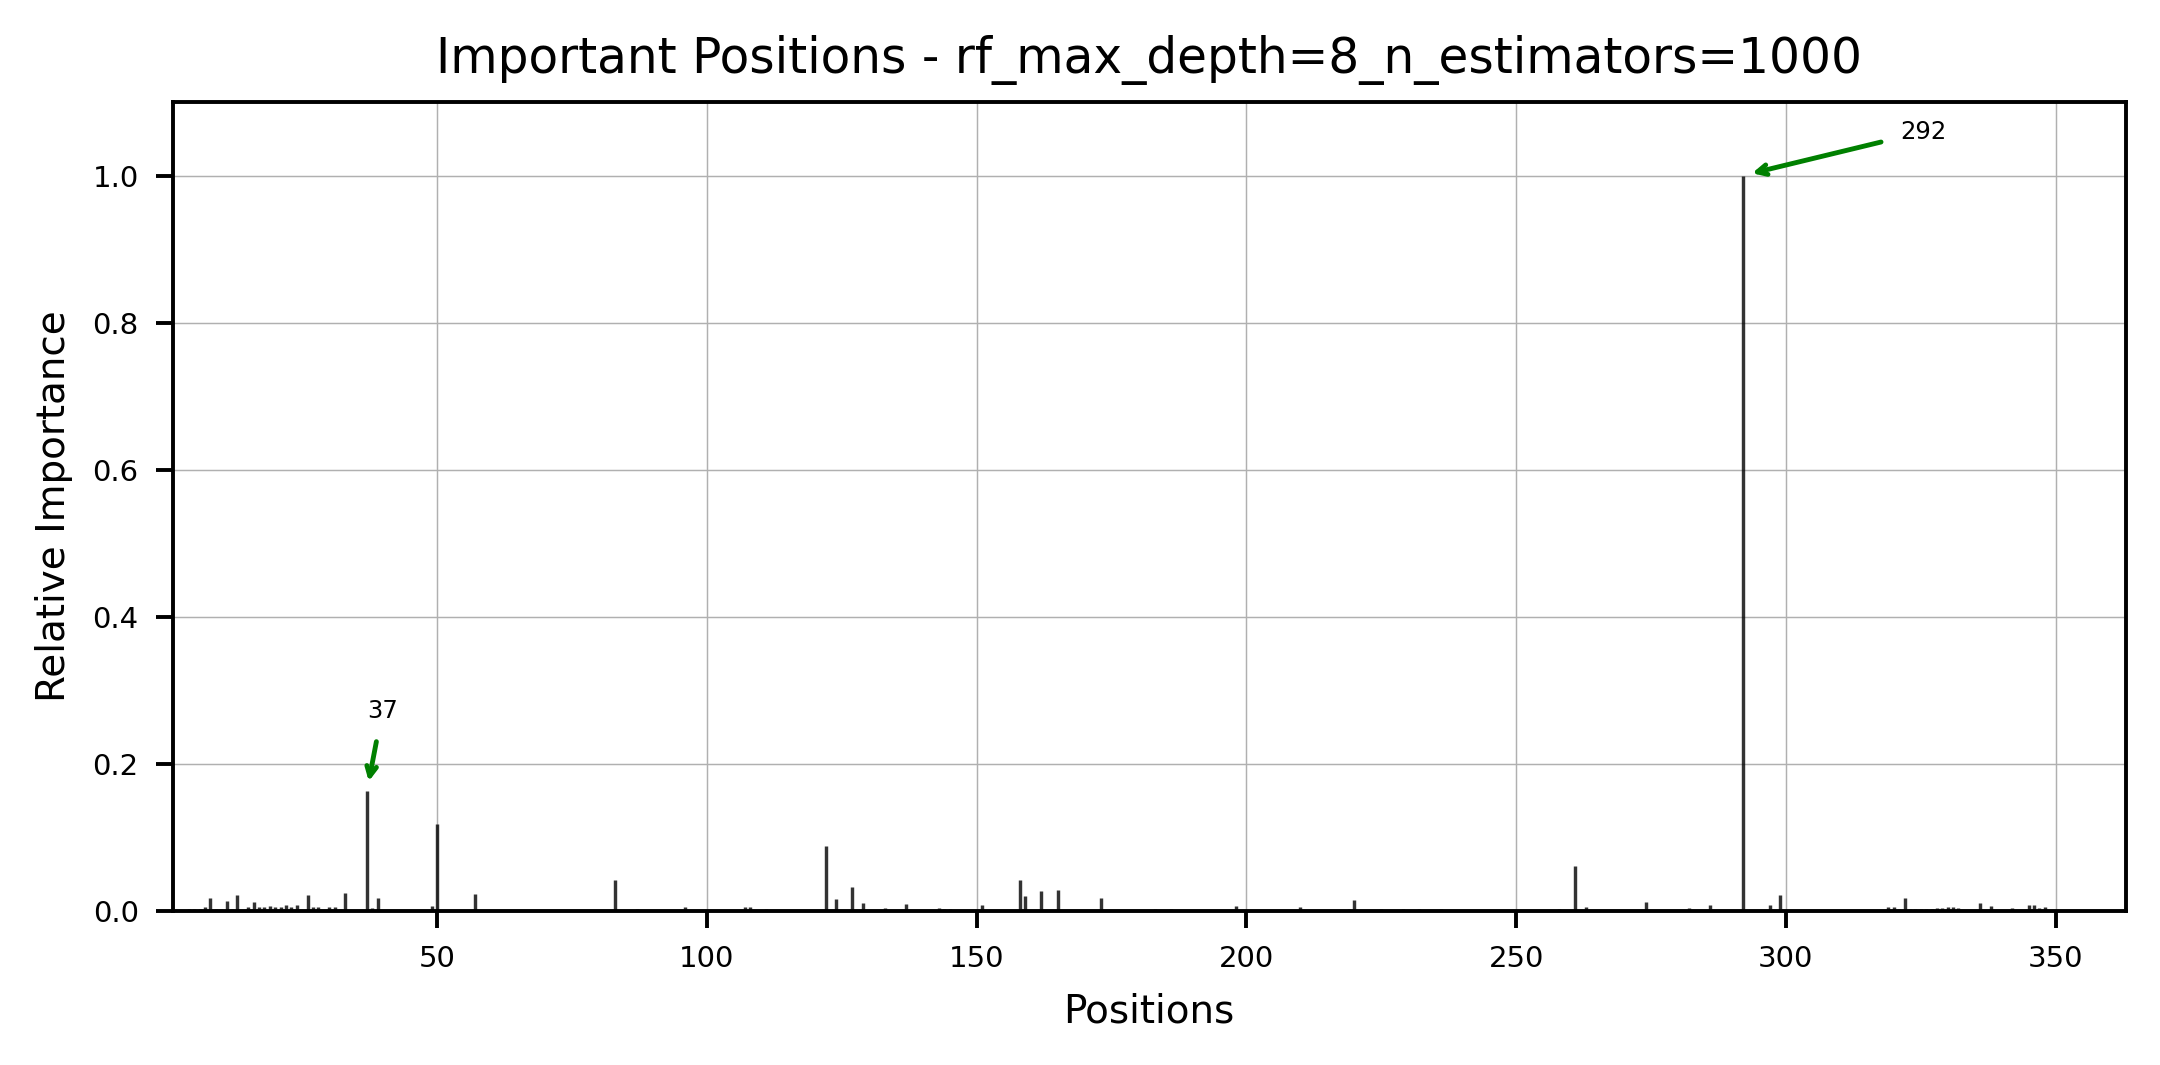

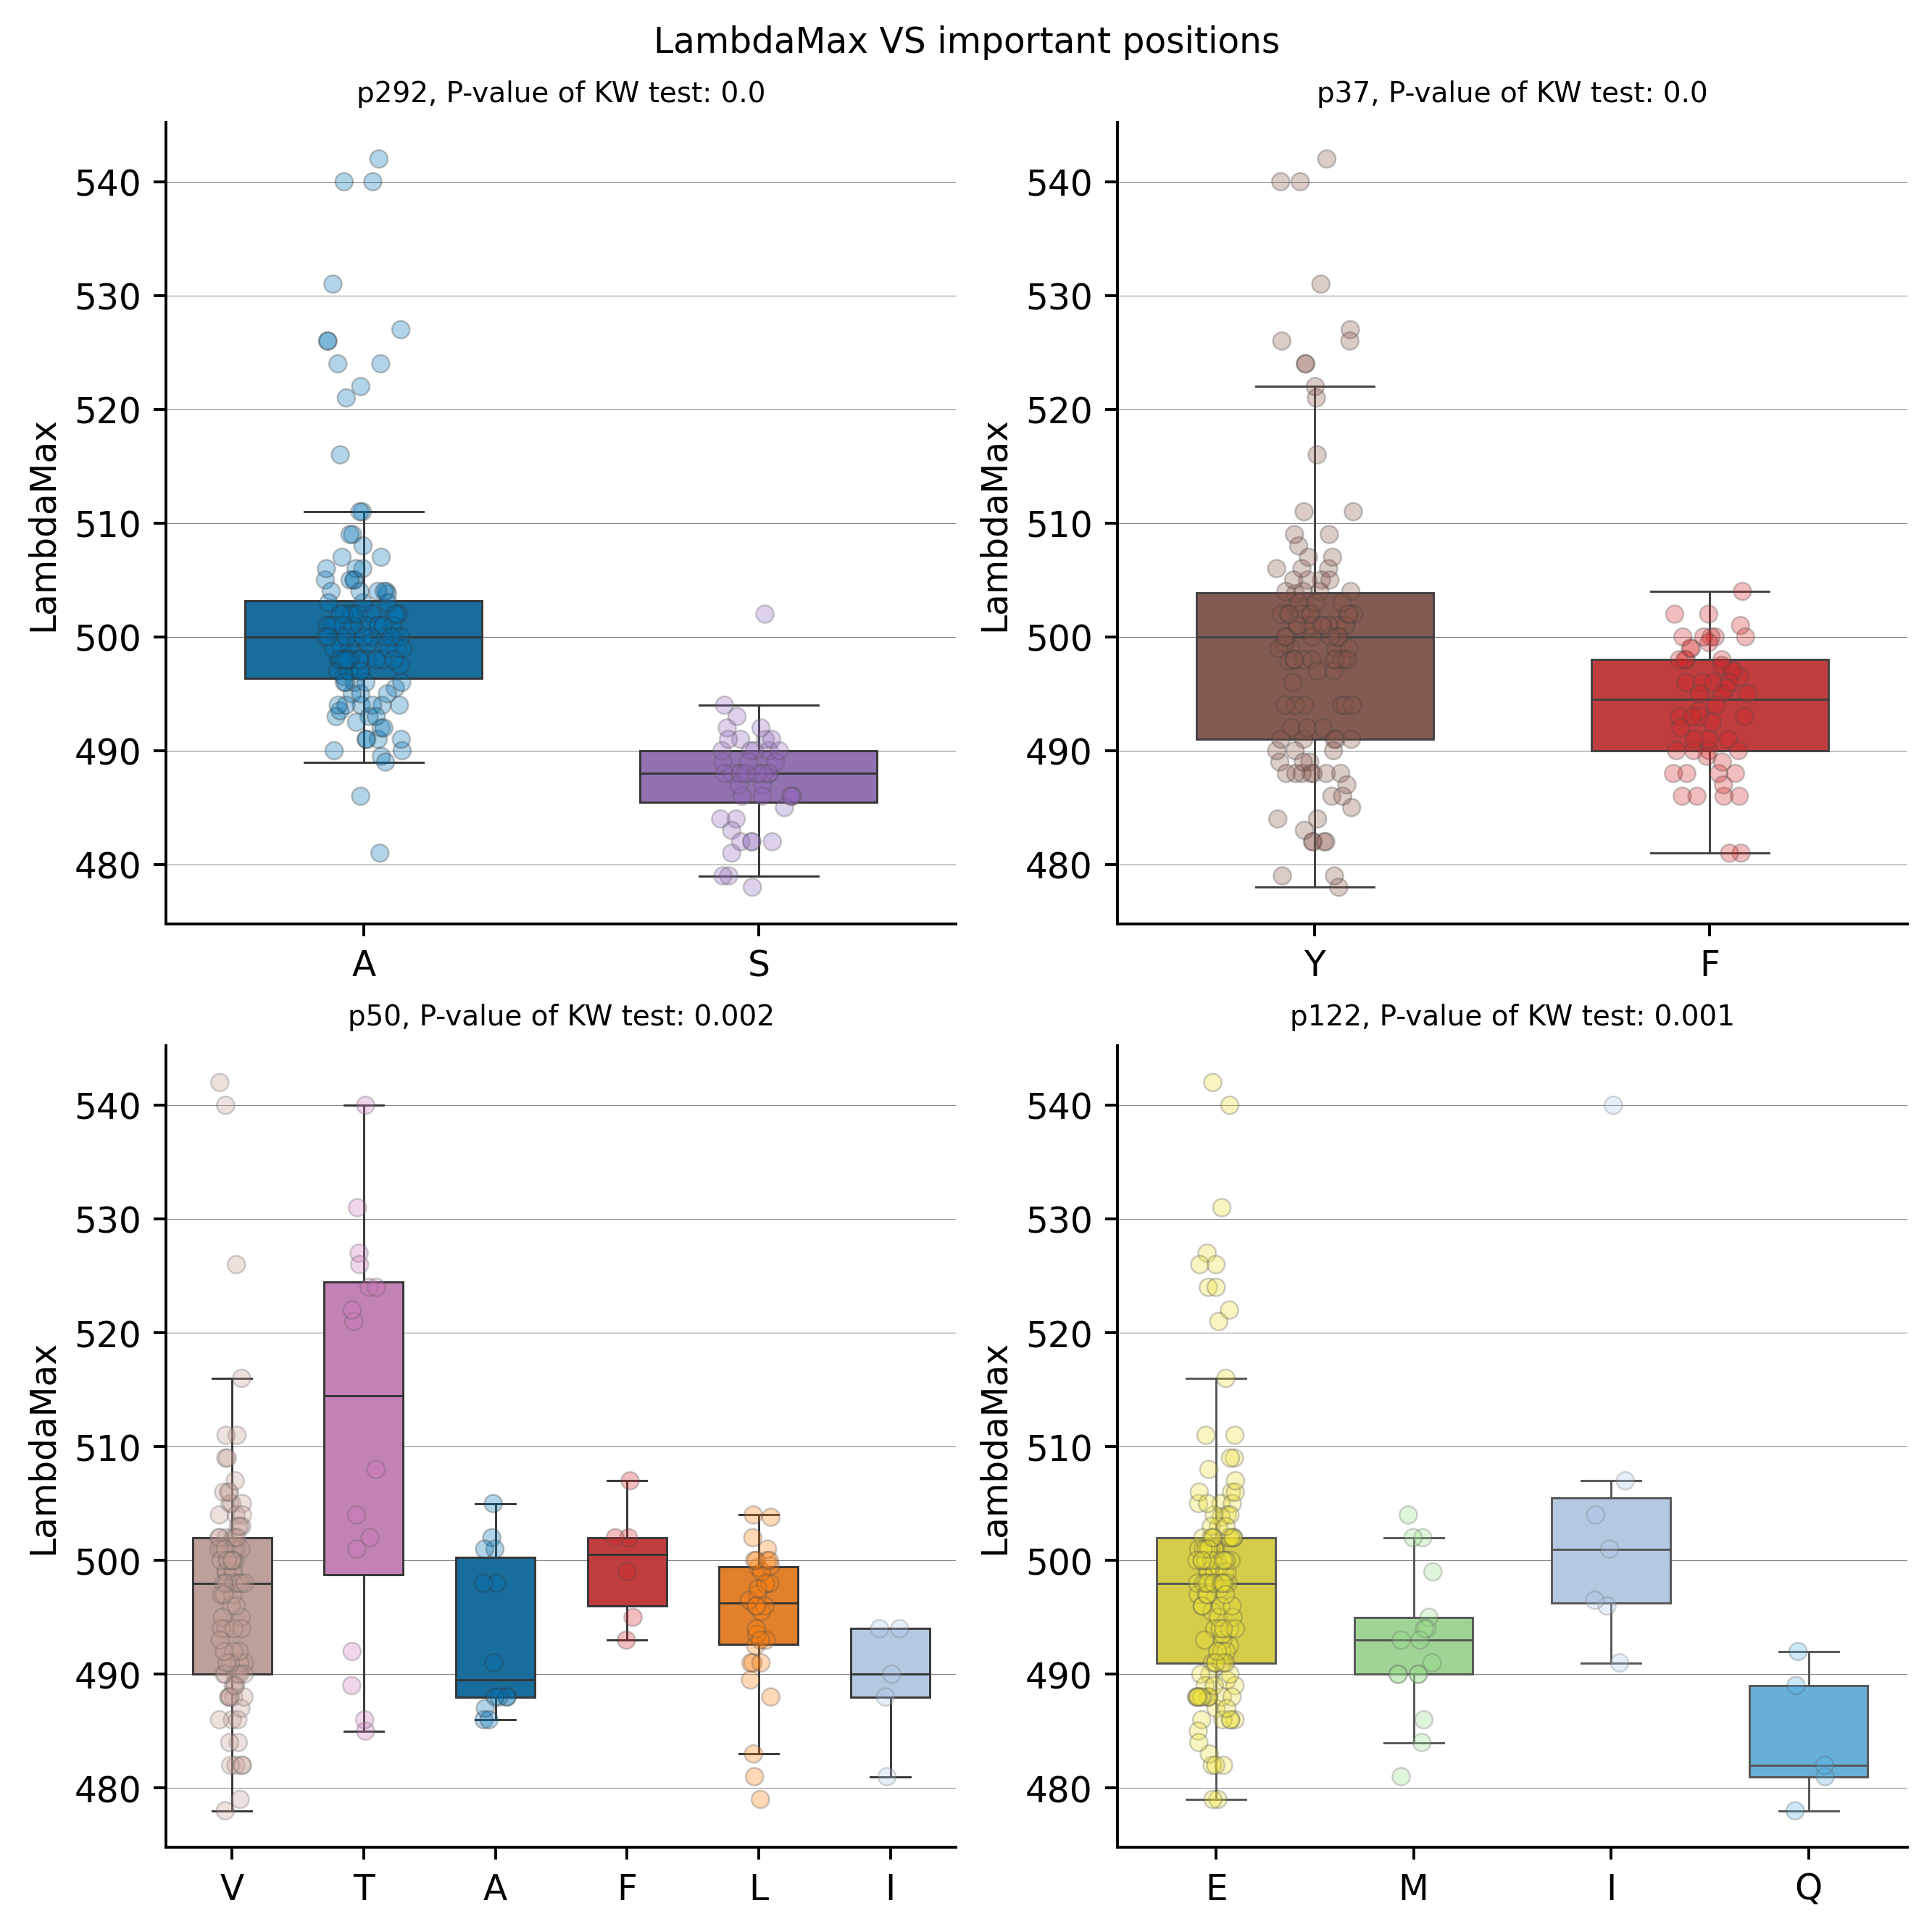

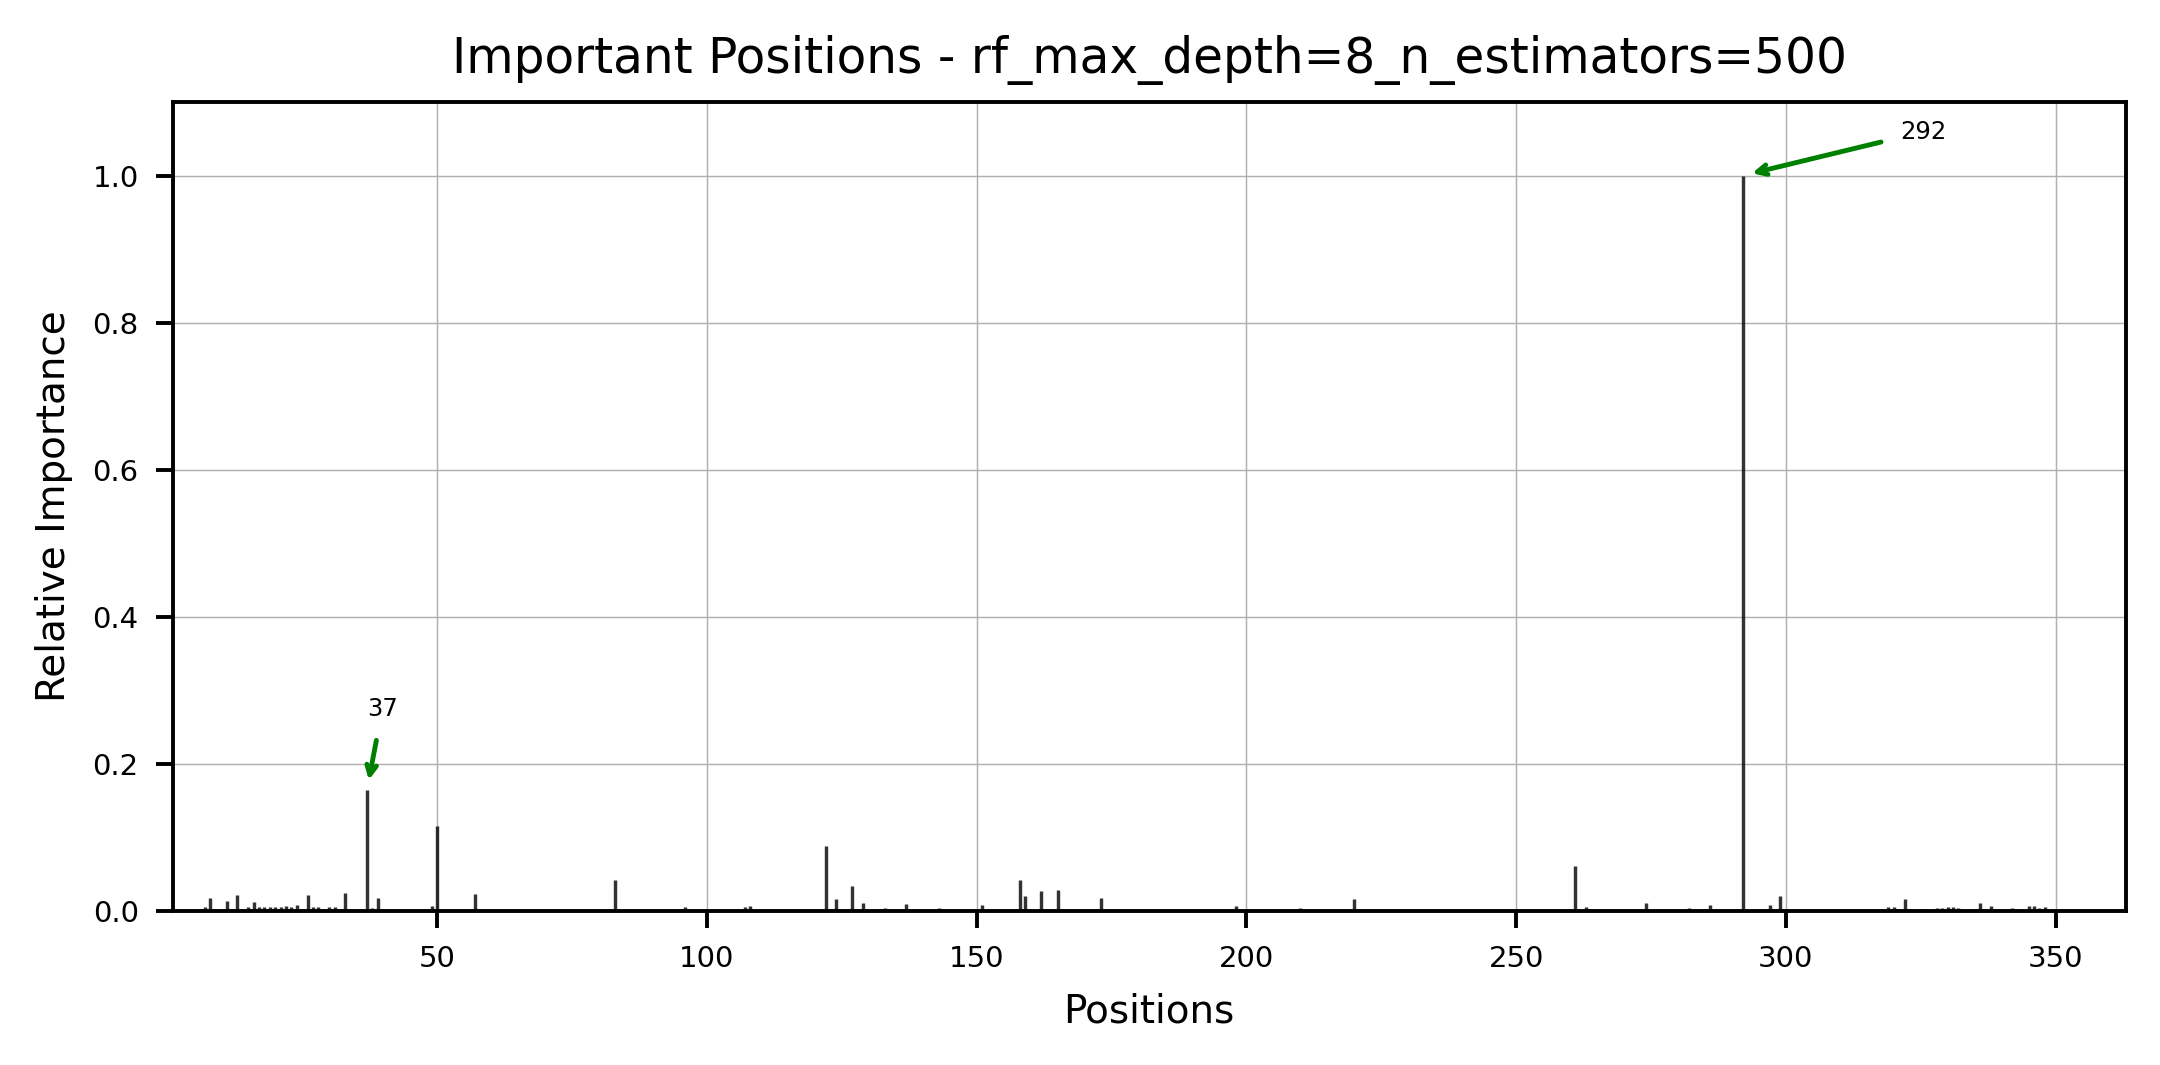

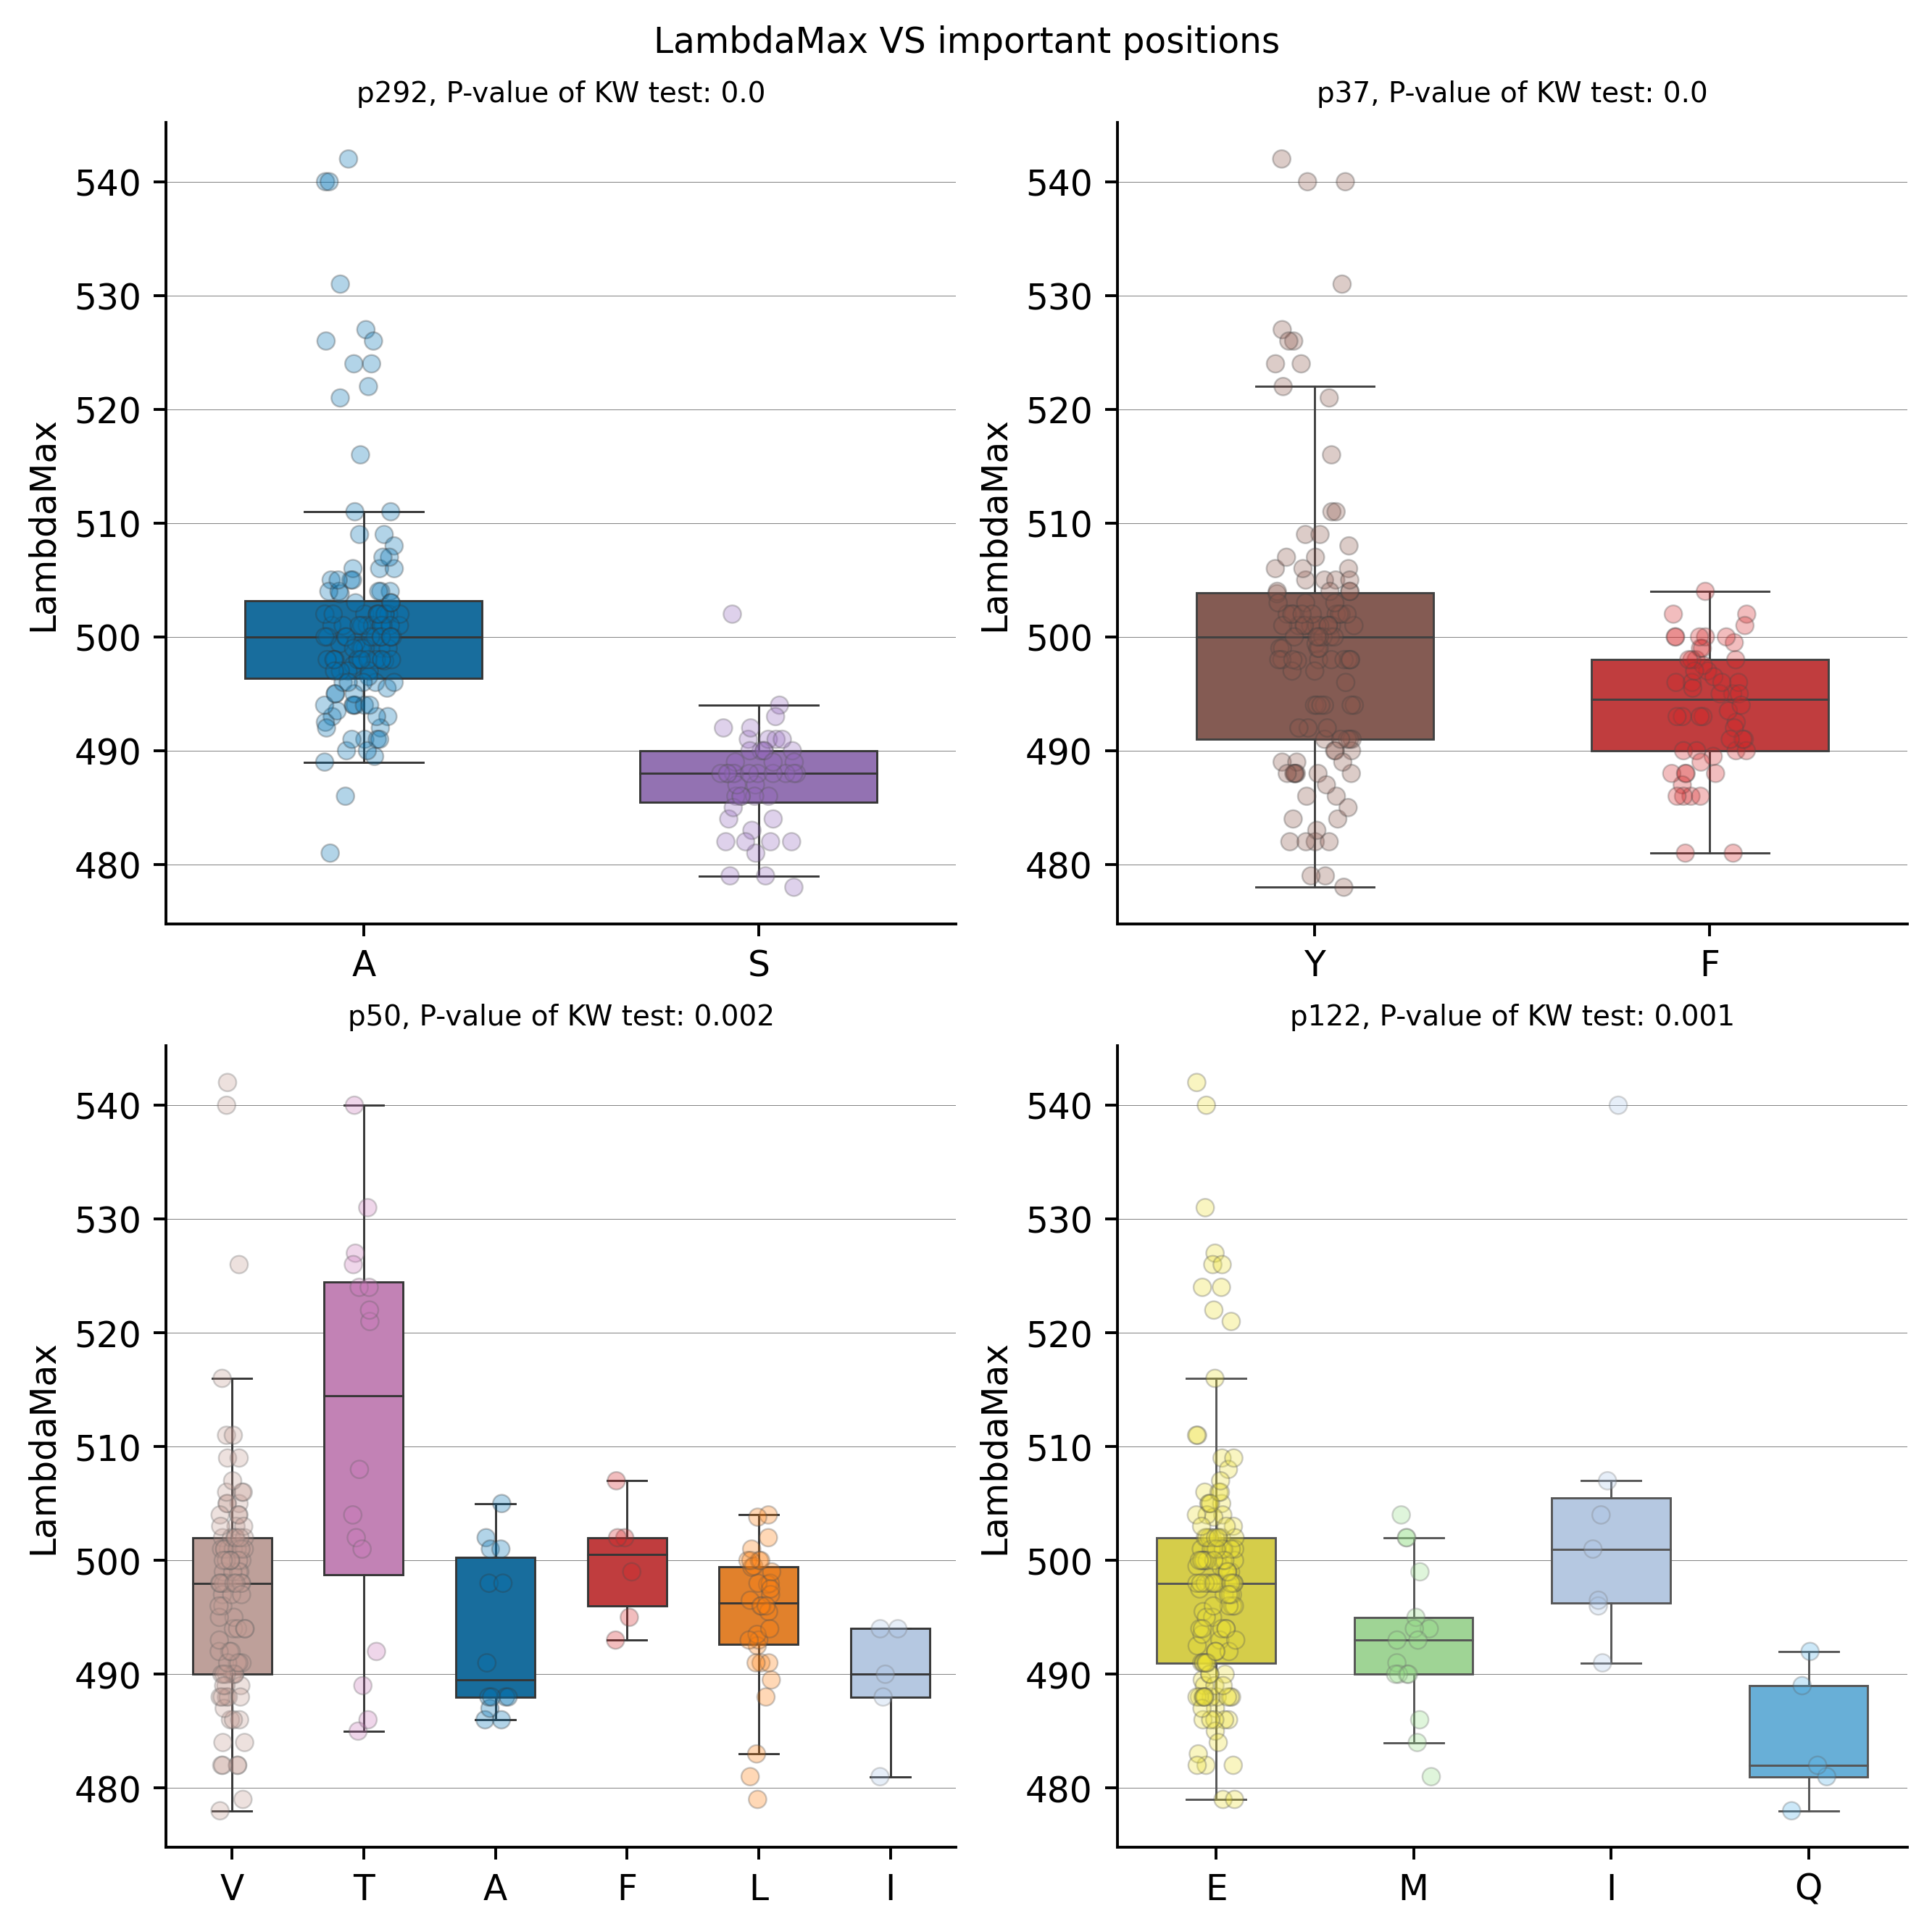

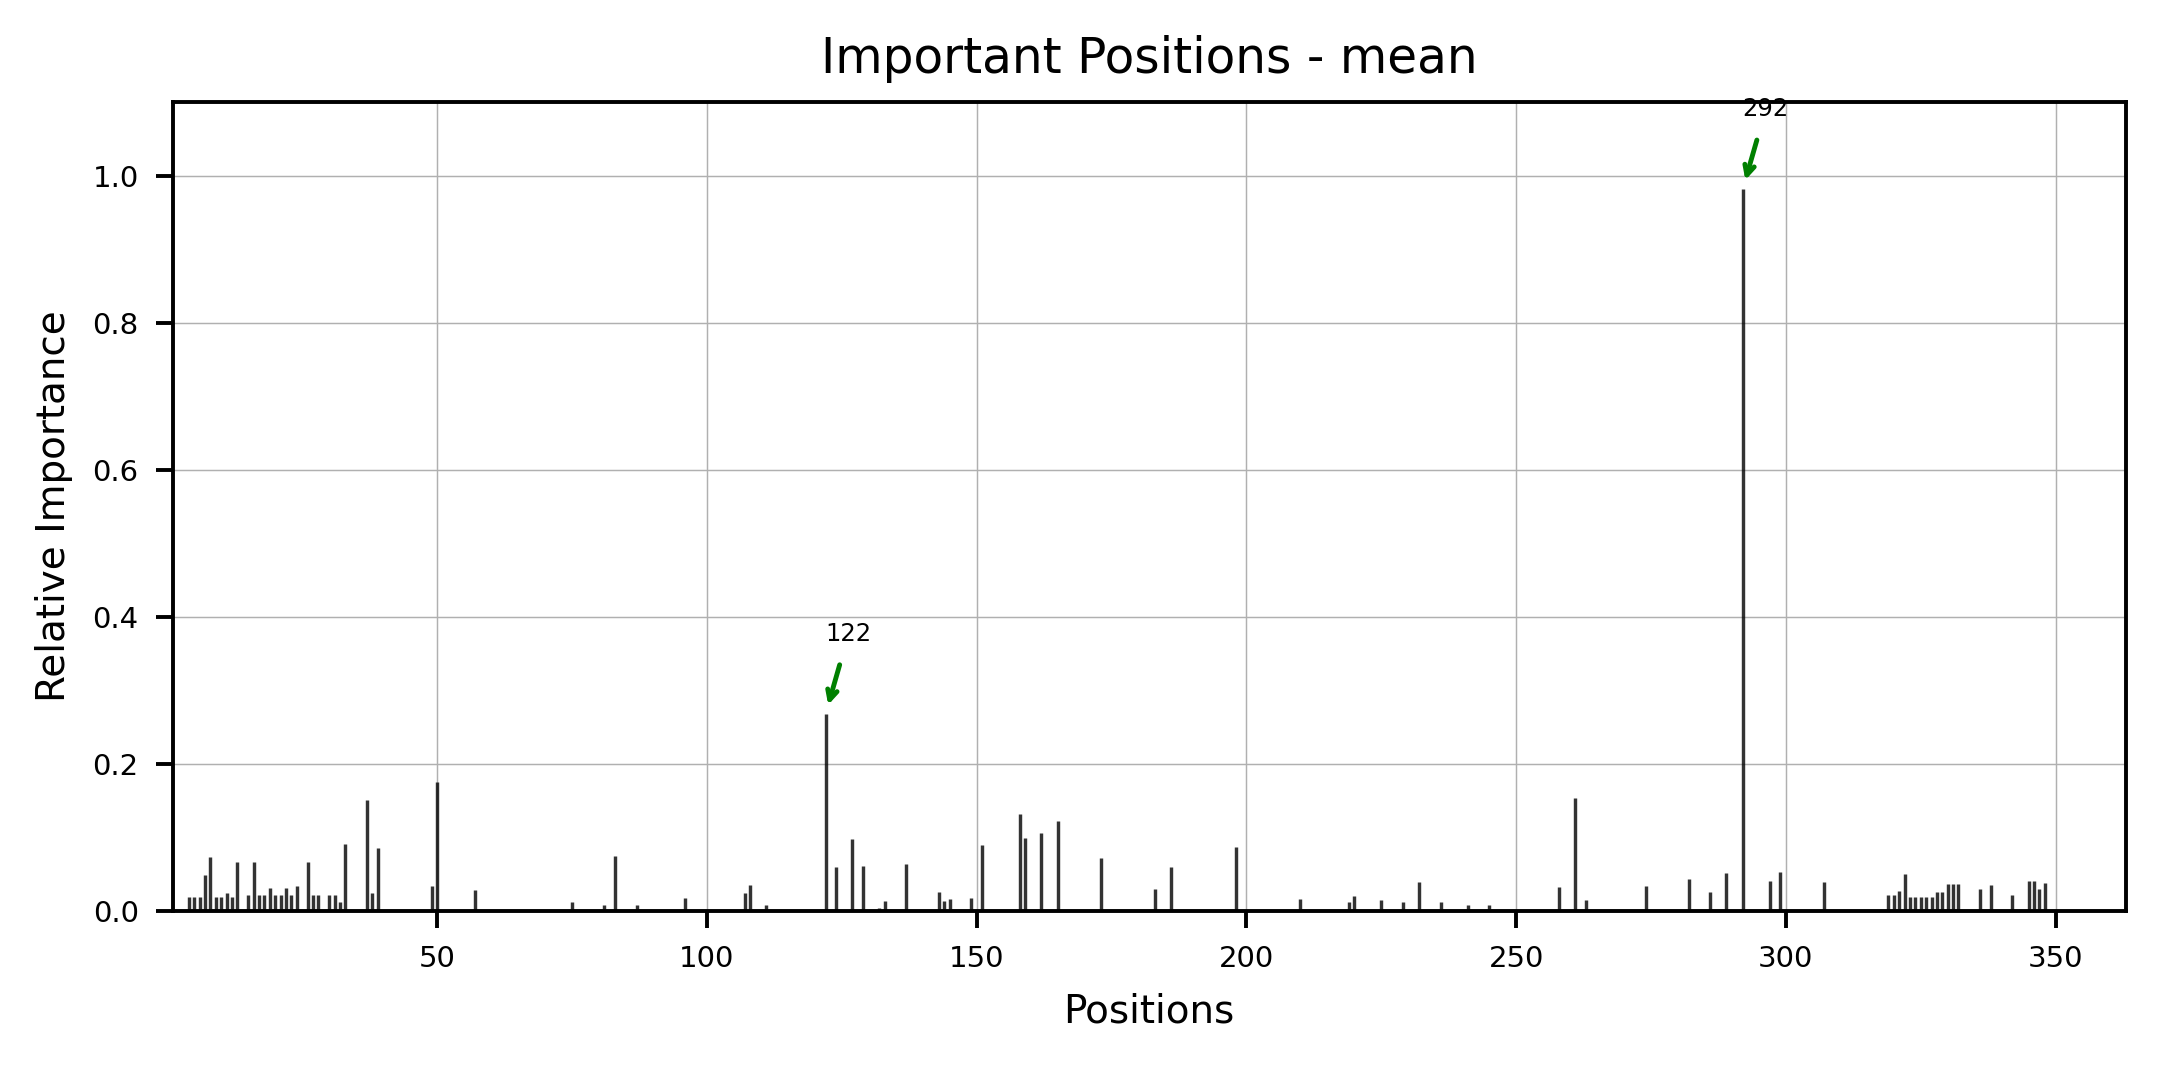

In [30]:
for key in trained_models.keys():
    if key == 'mean':
        # plot the mean importance
        viz.dp_plot(importance=trained_models[key], imp_col='mean', model_name=key, annotate=2, report_dir=report_dir)
    else:
        
        viz.dp_plot(importance= trained_models[key]['importance'], imp_col='standard_value', 
                model_name=key, annotate=2,report_dir=report_dir)
        
        viz.plot_imp_model(importance=trained_models[key]['importance'],
                           X_train=df.loc[:, df.columns != mt],
                           y_train=df.loc[:, mt],
                           model_name=key, meta_var=mt, model_type=anaType,
                           report_dir=report_dir)

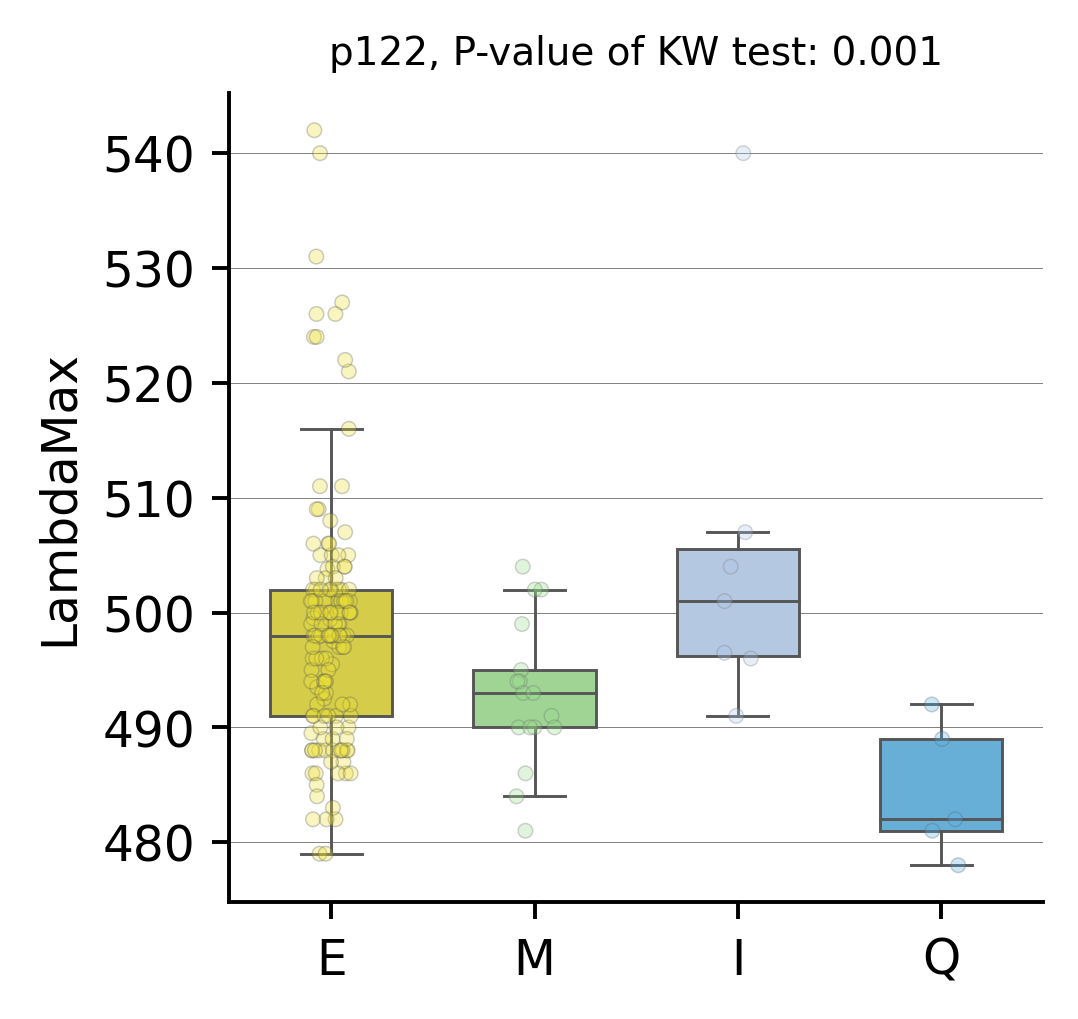

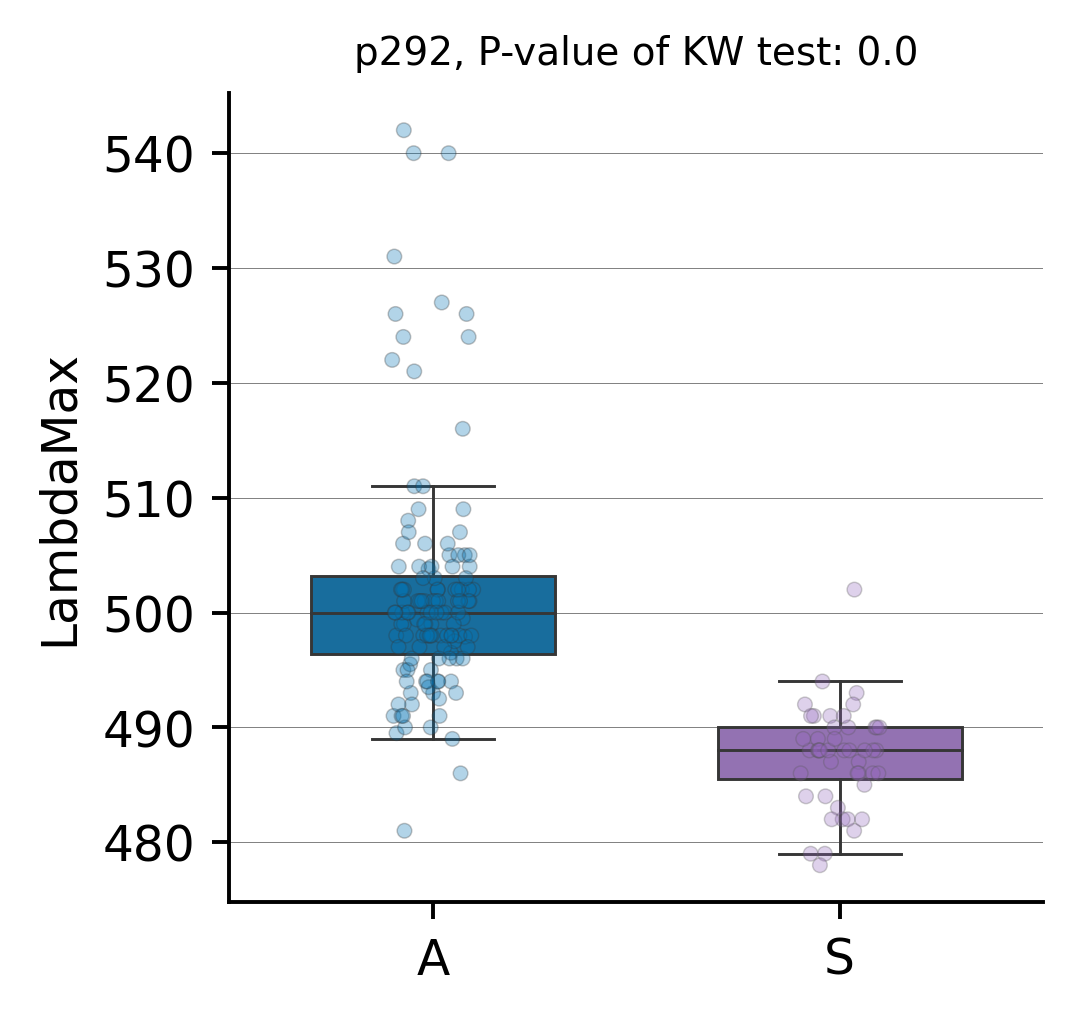

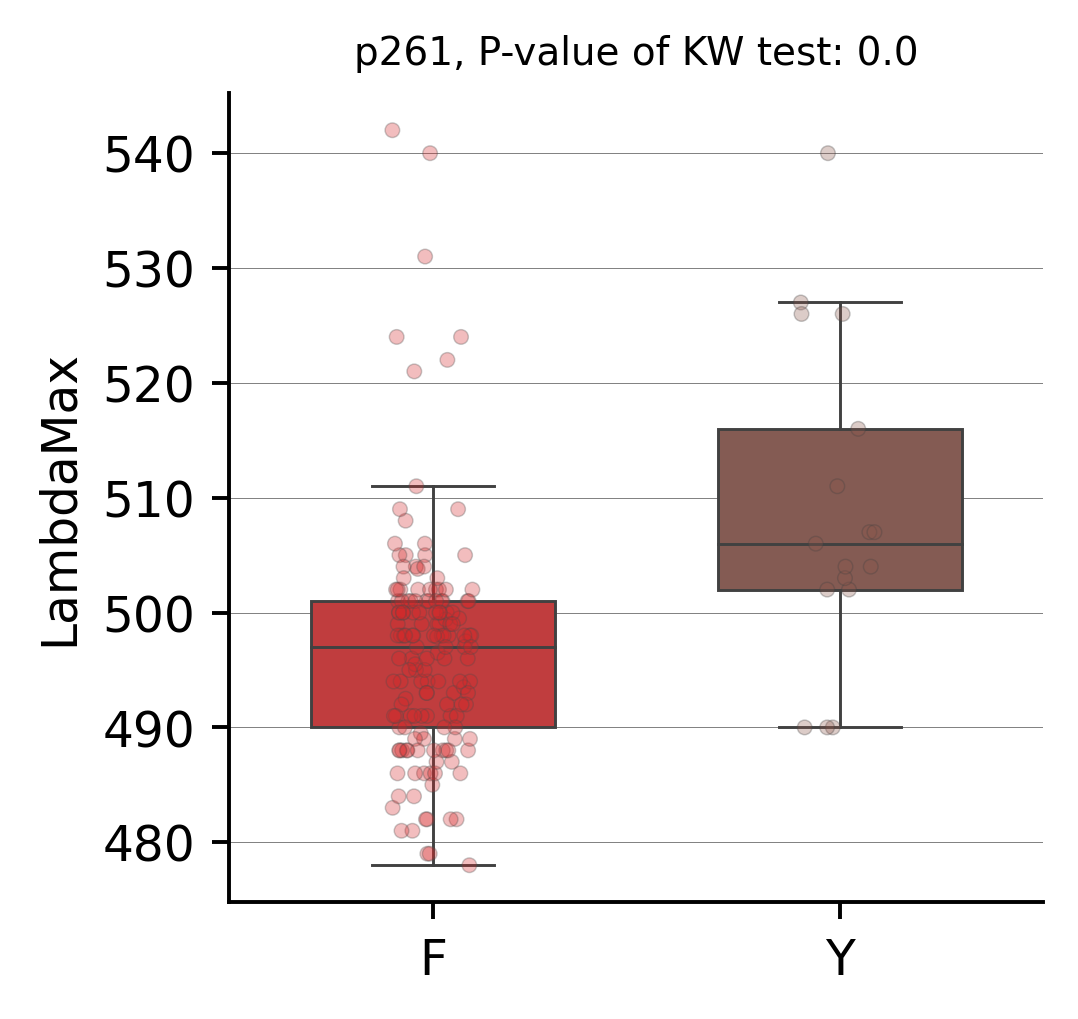

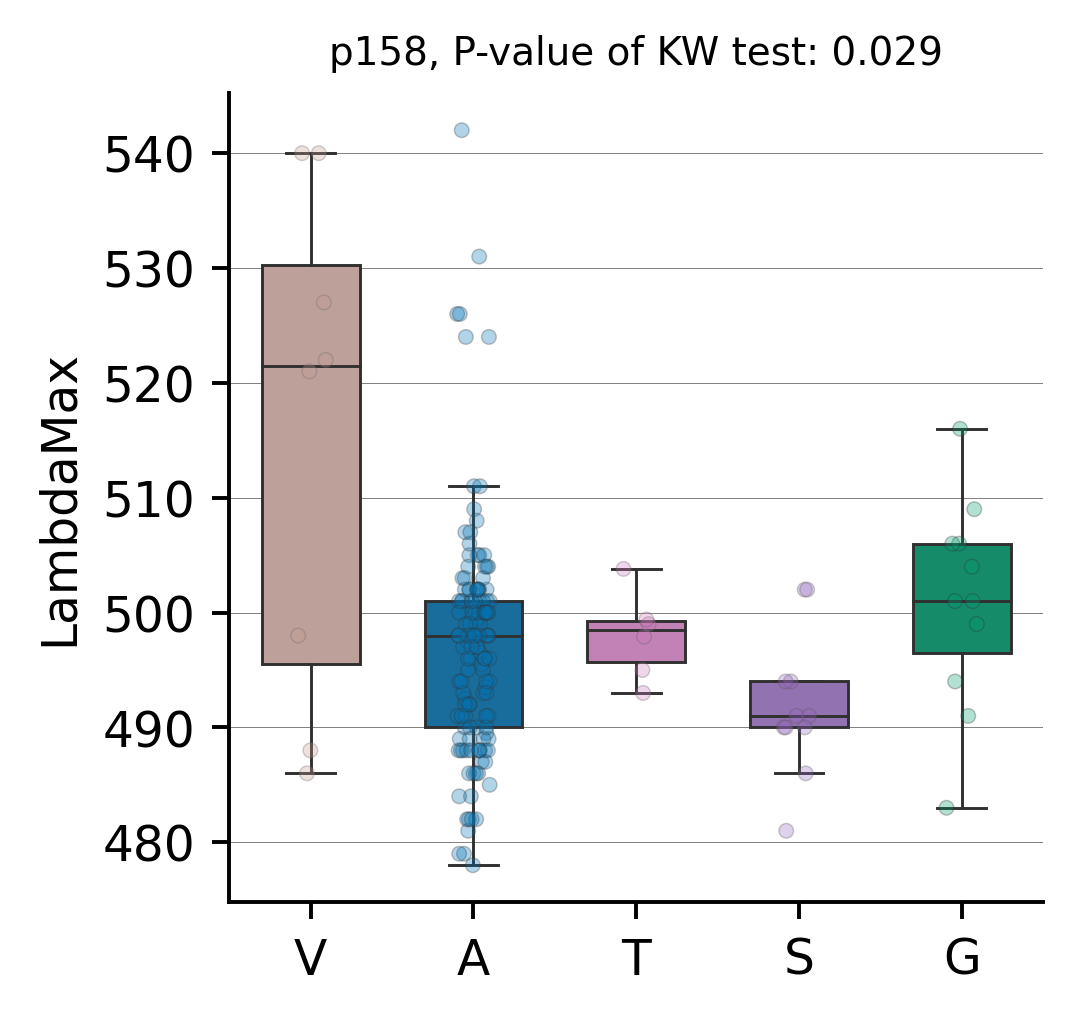

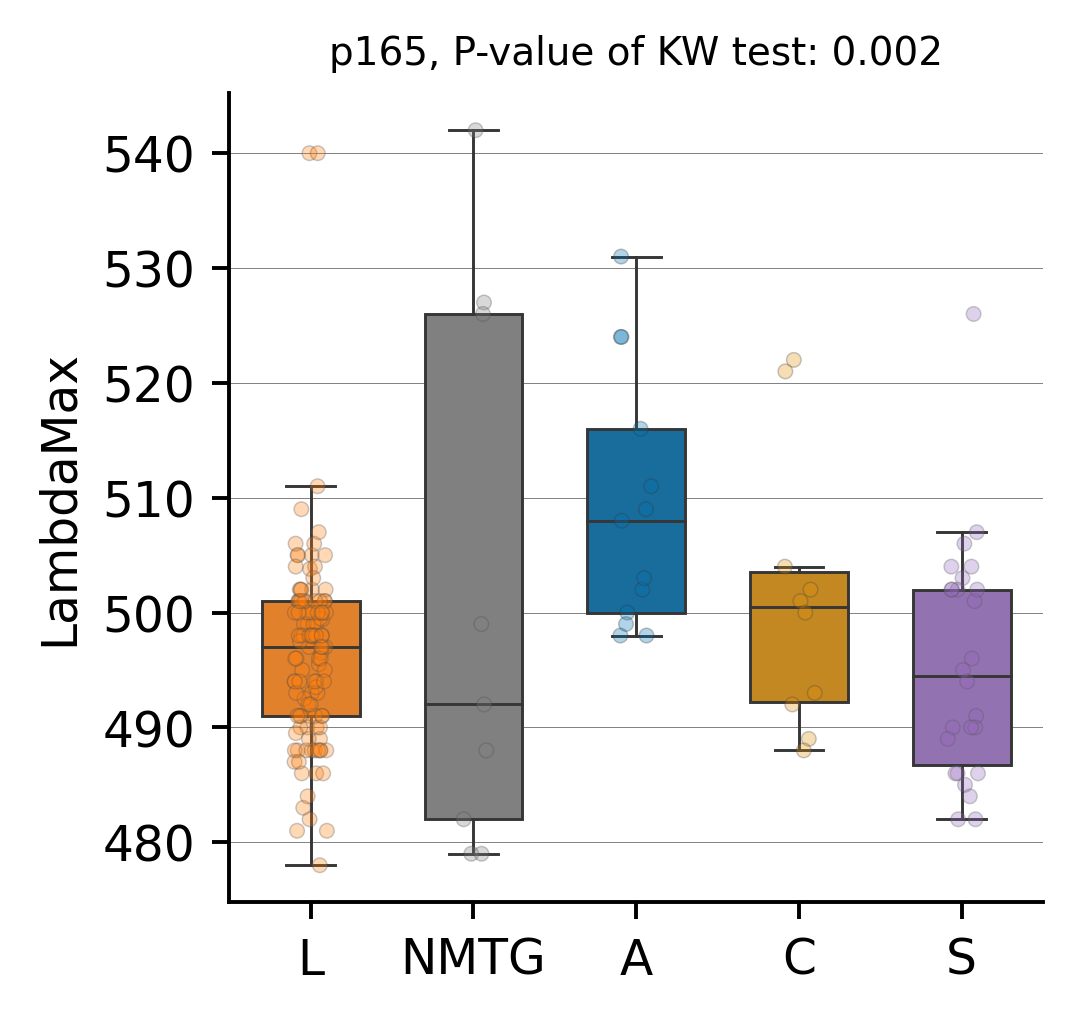

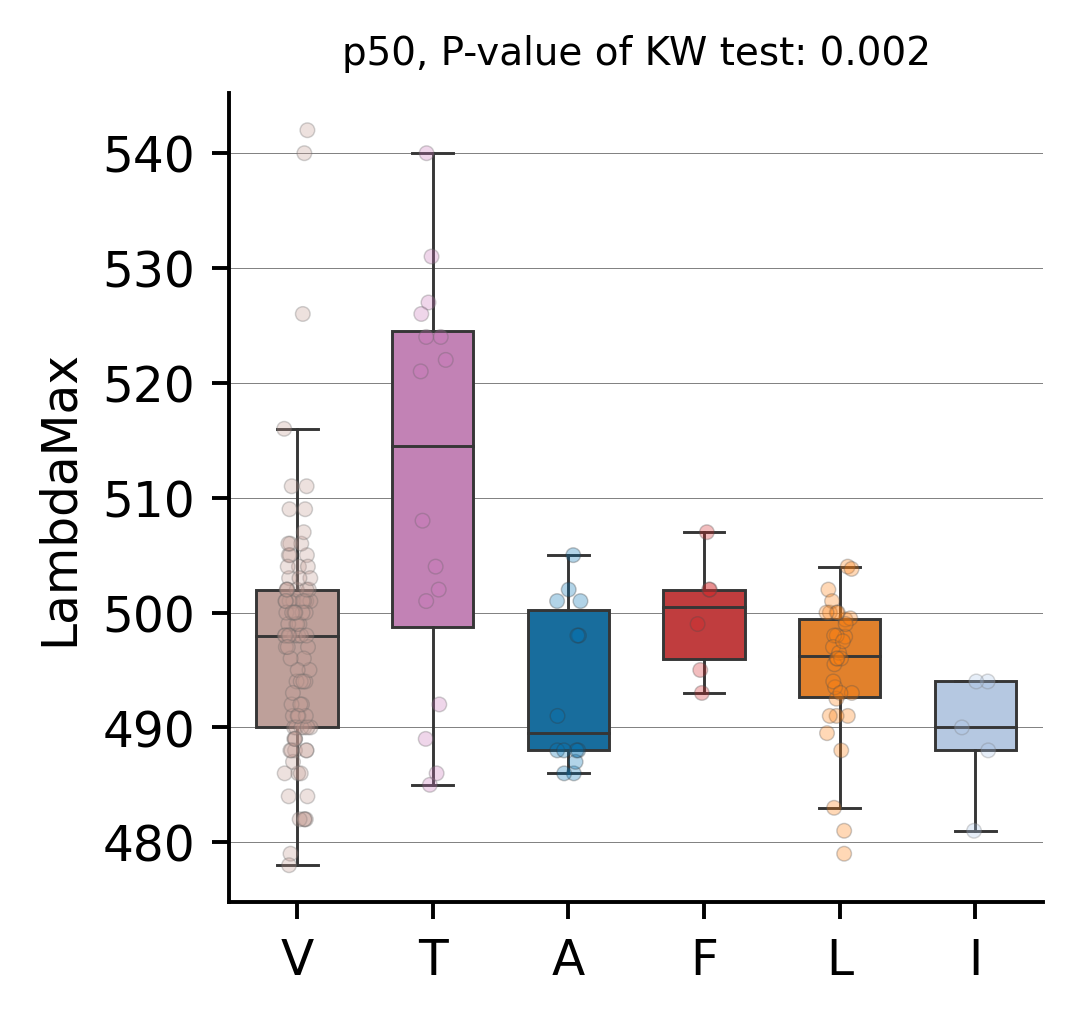

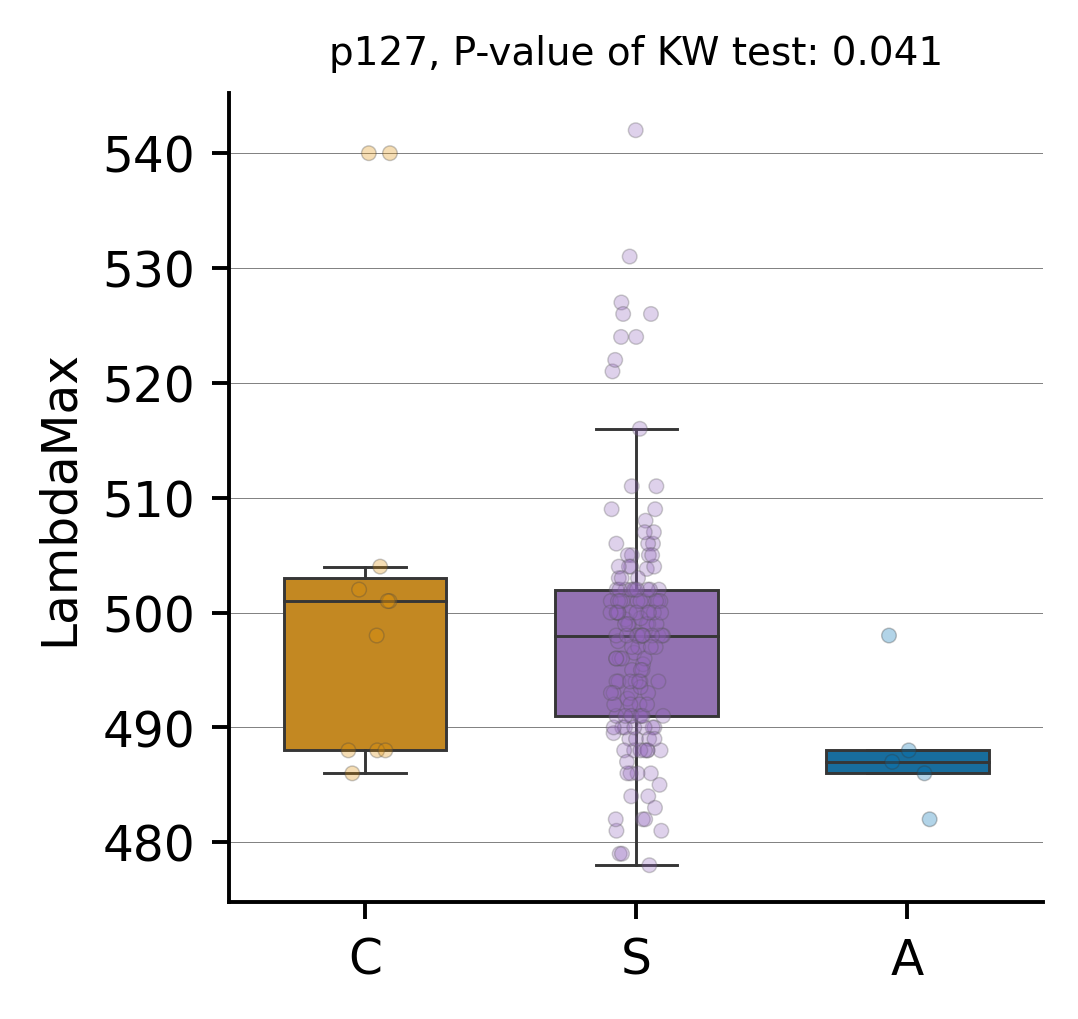

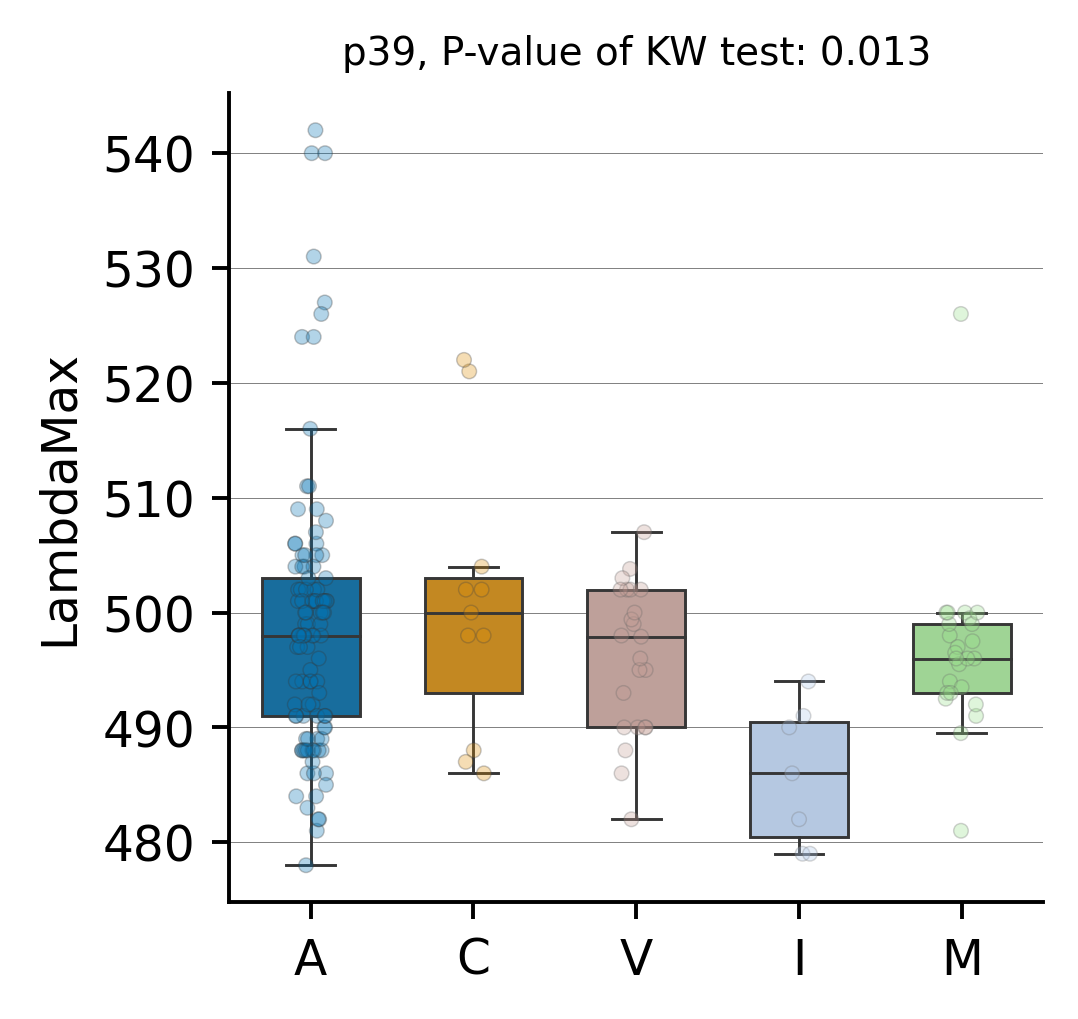

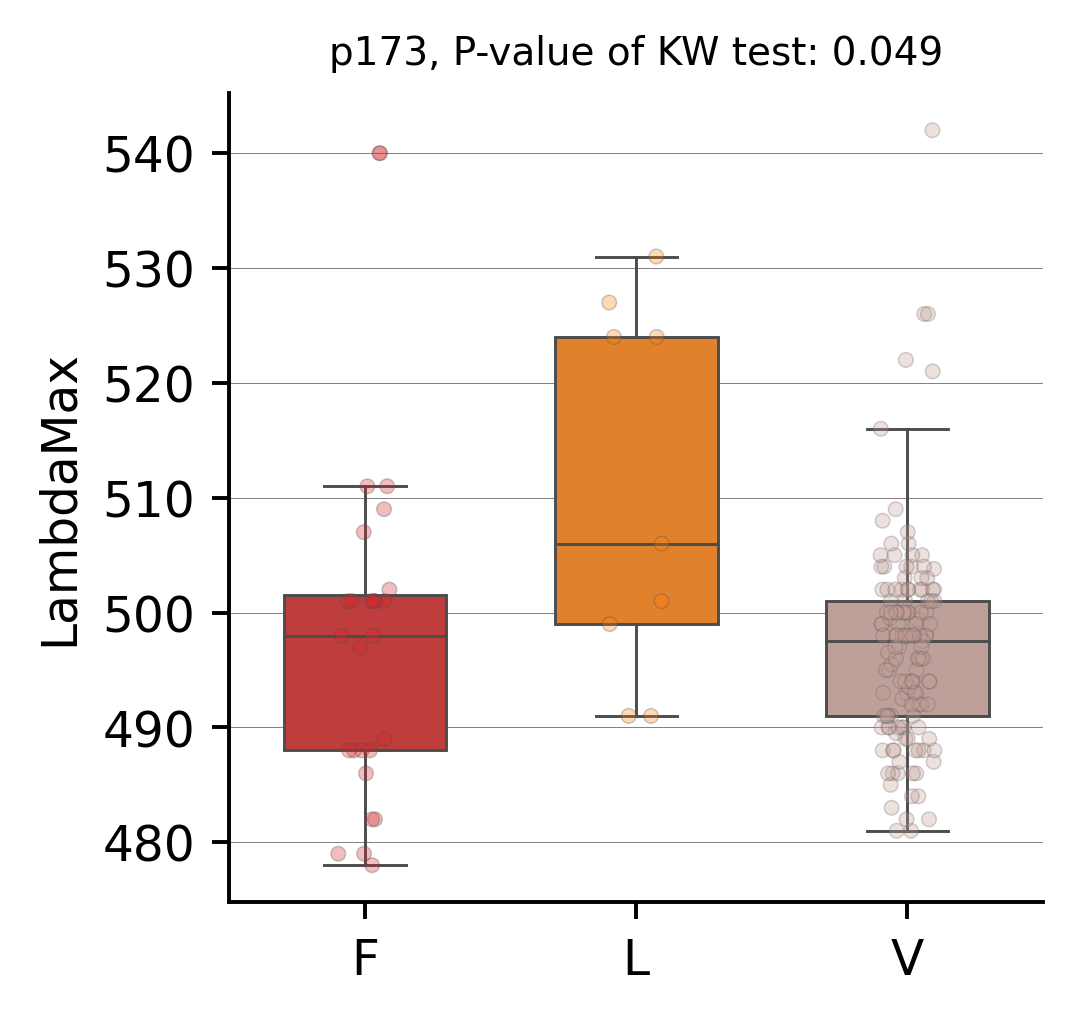

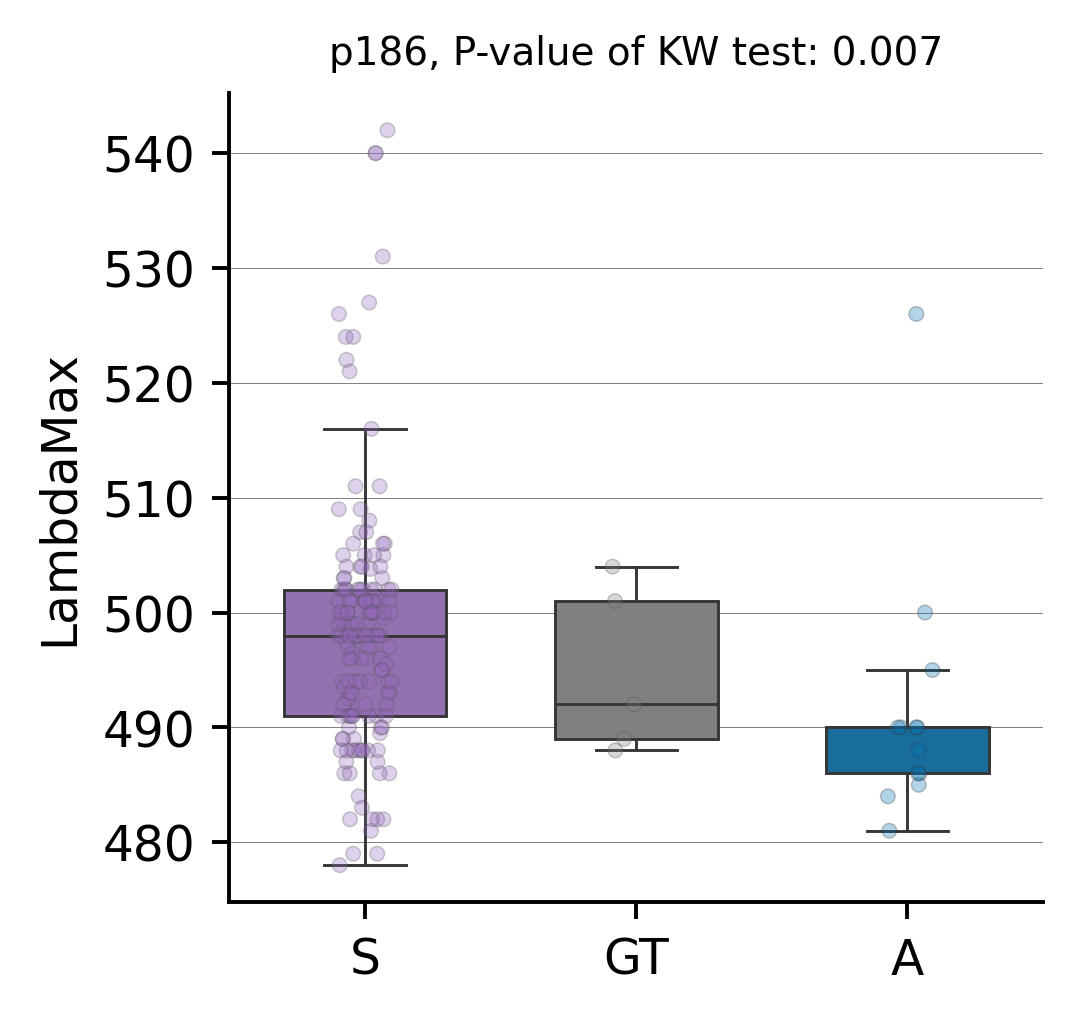

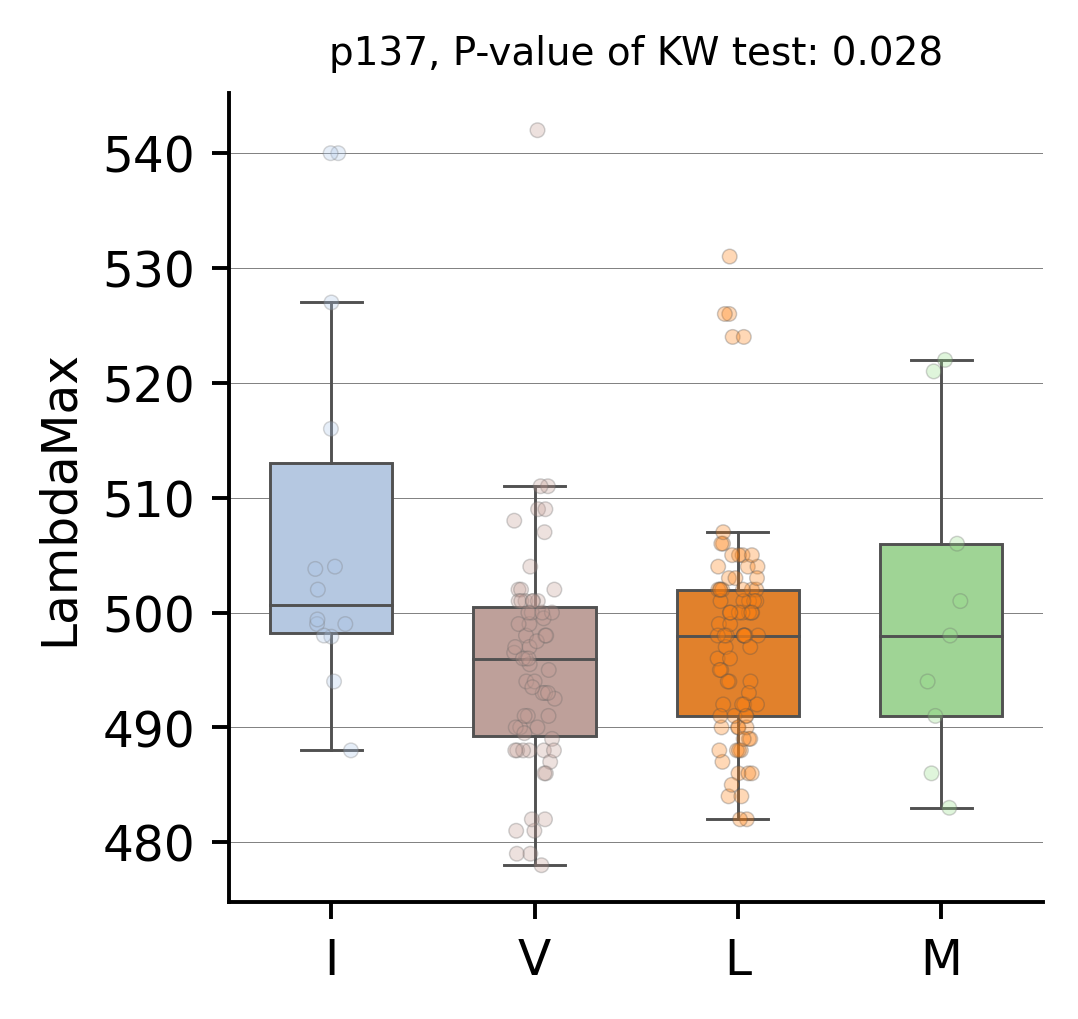

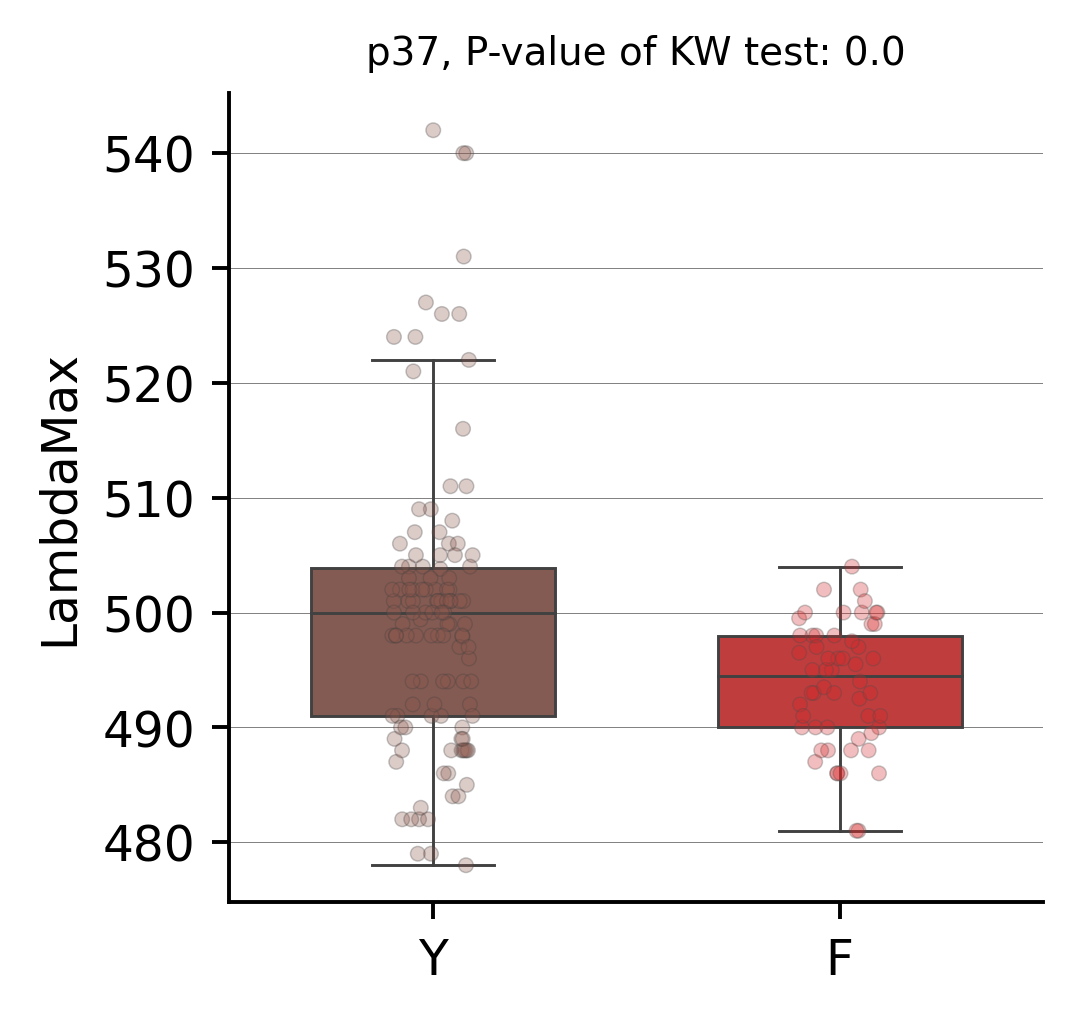

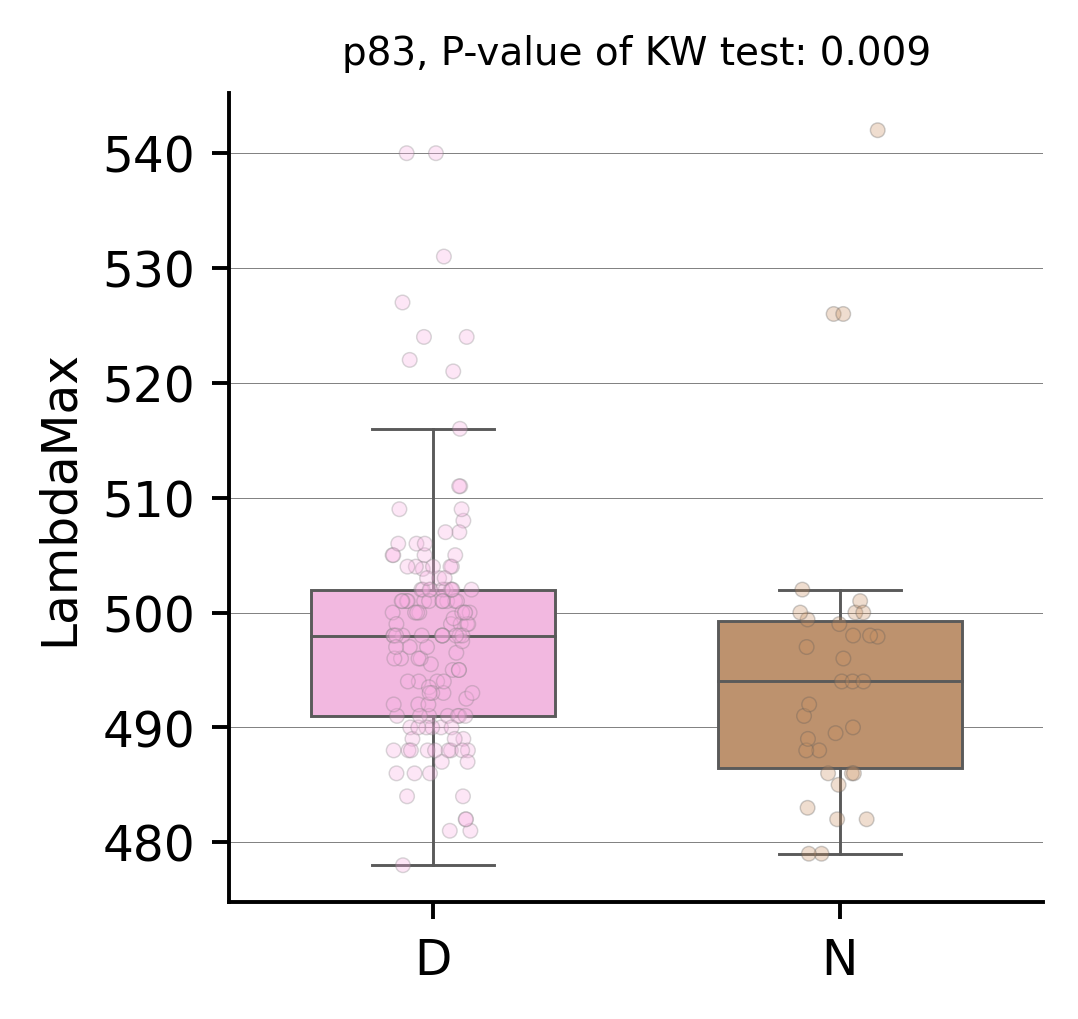

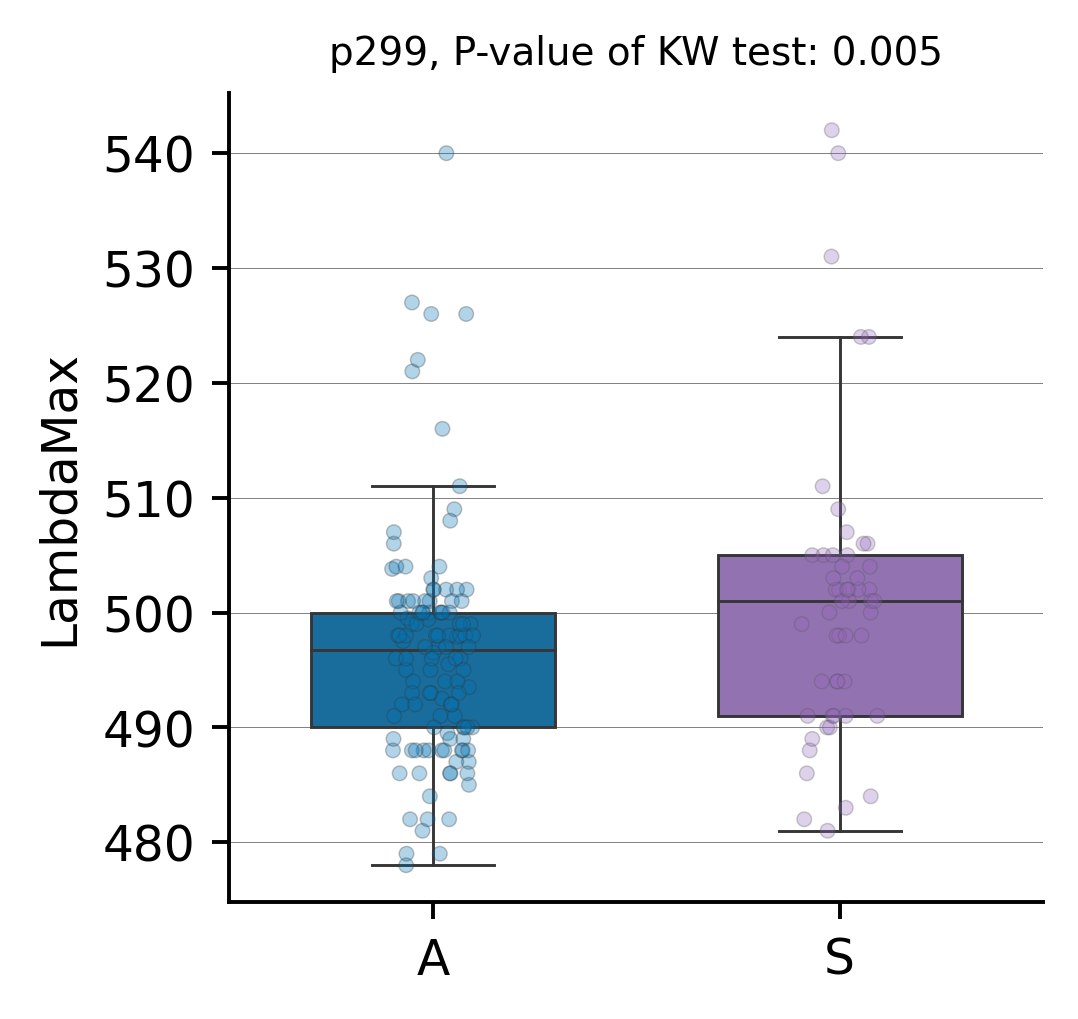

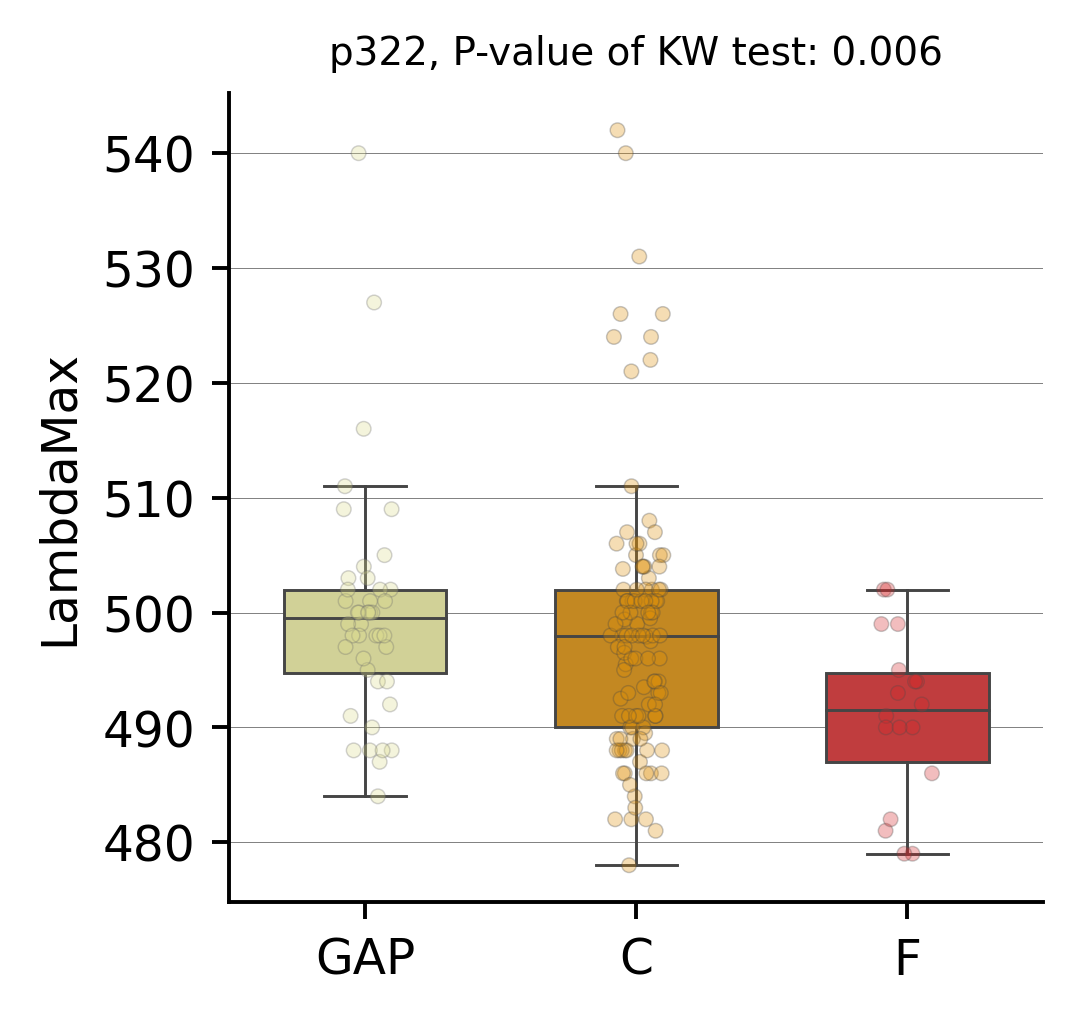

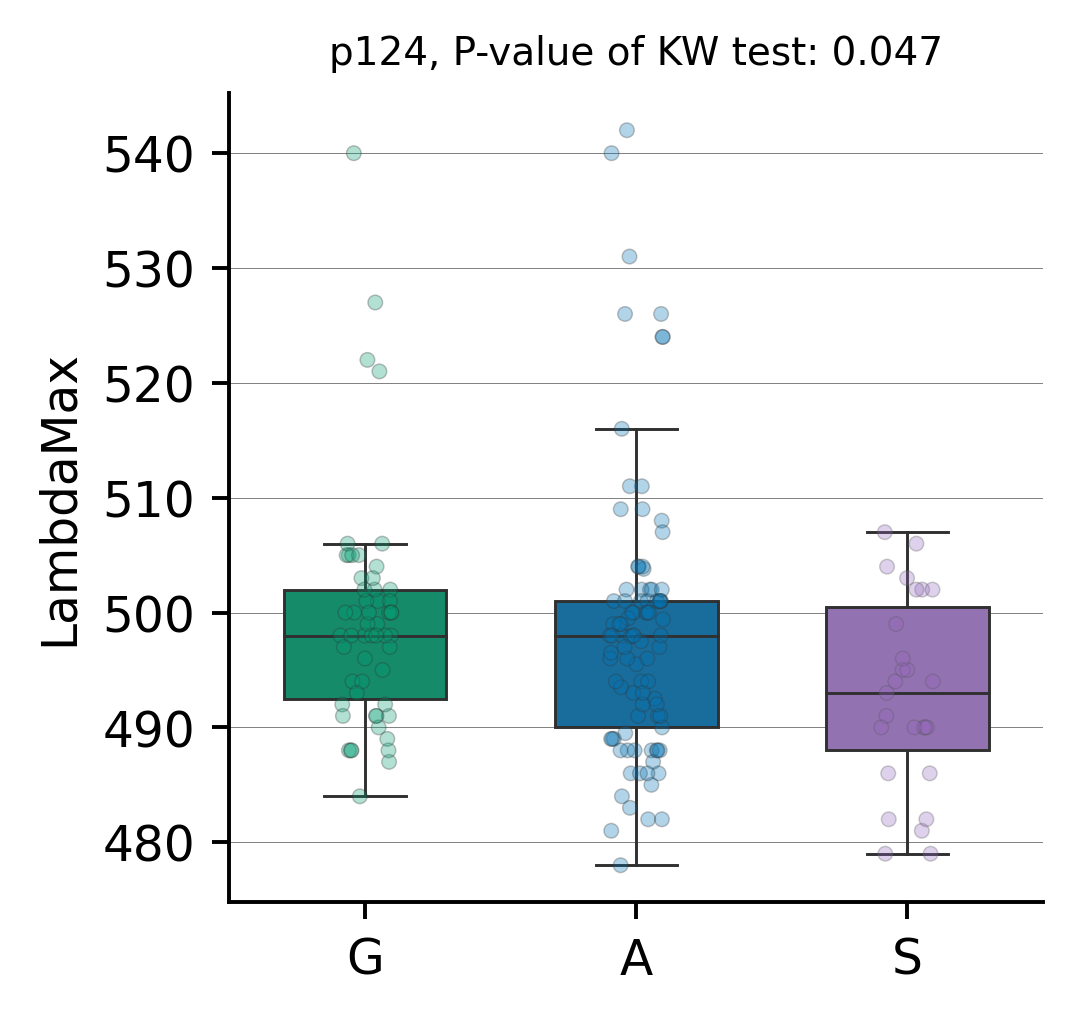

In [31]:
# visualizing top positions  
plots = viz.plot_imp_all(trained_models=trained_models,
                         X_train=df.loc[:, df.columns != mt],
                         y_train=df.loc[:, mt],
                         meta_var=mt,
                         model_type=anaType,
                         report_dir=report_dir,max_plots=100)